In [ ]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
color_pal=sns.color_palette()
!pip install --upgrade xgboost
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 105.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
df=pd.read_csv("/content/oil and gas.csv")
df

,Symbol,Date,Open,High,Low,Close,Volume,Currency
0,Brent Oil,2000-01-04,23.9000,24.7000,23.8900,24.3900,32509,USD
1,Brent Oil,2000-01-05,24.2500,24.3700,23.7000,23.7300,30310,USD
2,Brent Oil,2000-01-06,23.5500,24.2200,23.3500,23.6200,44662,USD
3,Brent Oil,2000-01-07,23.5700,23.9800,23.0500,23.0900,34826,USD
4,Brent Oil,2000-01-10,23.0400,23.7800,23.0400,23.7300,26388,USD
...,...,...,...,...,...,...,...,...
23019,Heating Oil,2022-06-13,4.3612,4.3762,4.1949,4.2834,46406,USD
23020,Heating Oil,2022-06-14,4.2749,4.4570,4.2488,4.3940,36652,USD
23021,Heating Oil,2022-06-15,4.3816,4.6070,4.3557,4.5470,36908,USD
23022,Heating Oil,2022-06-16,4.5320,4.5825,4.4124,4.5713,28269,USD


In [ ]:
df1 = df[df['Symbol'] == 'Brent Oil'].reset_index(drop=True)
df2 = df[df['Symbol'] == 'Crude Oil WTI'].reset_index(drop=True)
df3 = df[df['Symbol'] == 'Natural Gas'].reset_index(drop=True)
df4 = df[df['Symbol'] == 'Heating Oil'].reset_index(drop=True)

In [ ]:
# Forecasting brent oil Date vs Close
df1_dropped = df1.drop(columns=['Symbol','Open','High','Low','Volume','Currency'])

In [ ]:
df1_final=df1_dropped.set_index('Date')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df1_final.fillna(0, inplace=True)
df1_final

,Close
Date,
2000-01-04,24.39
2000-01-05,23.73
2000-01-06,23.62
2000-01-07,23.09
2000-01-10,23.73
...,...
2022-06-13,122.27
2022-06-14,121.17
2022-06-15,118.51


<Axes: title={'center': 'Price per barrell'}, xlabel='Date'>

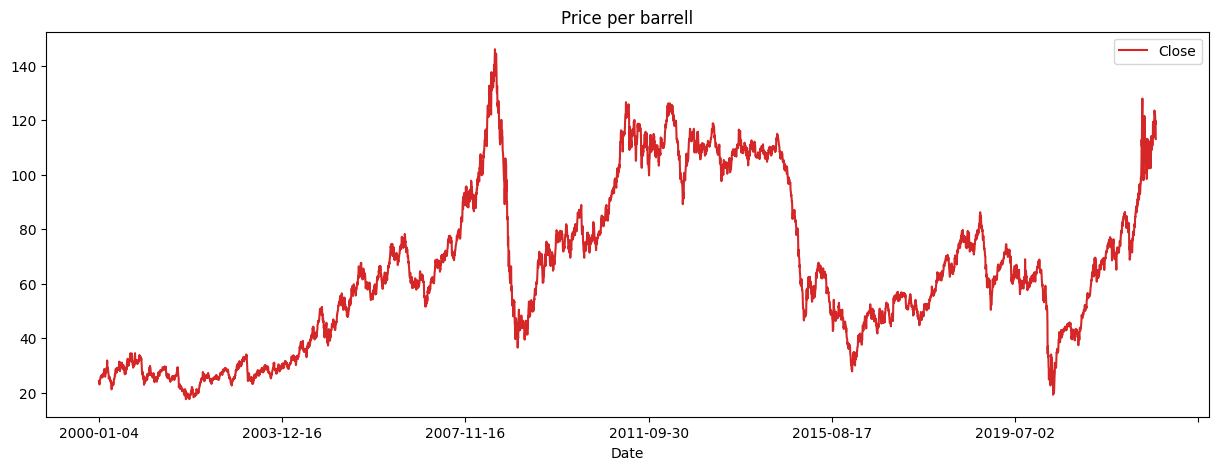

In [ ]:
df1_final.plot(style='-',figsize=(15,5),color=color_pal[3],title='Price per barrell')

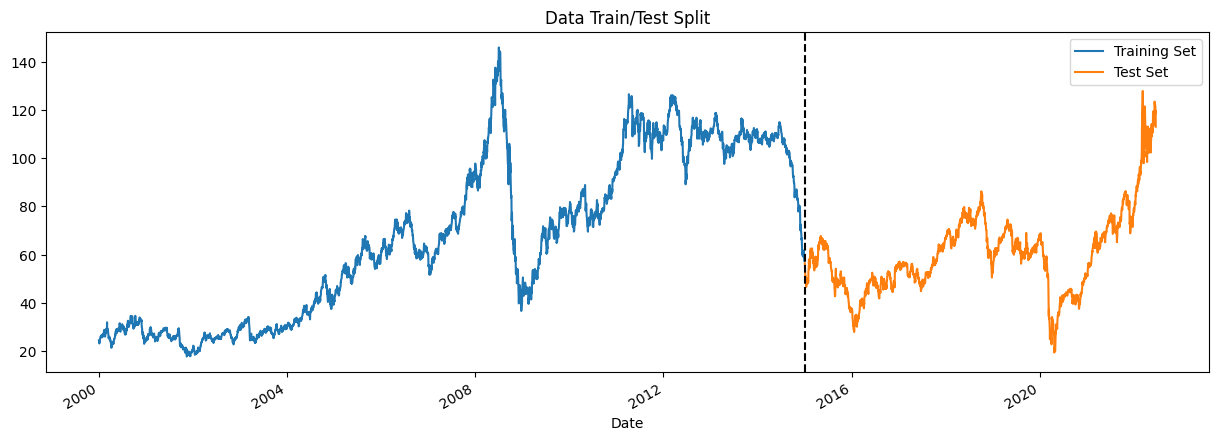

In [ ]:
df1_final.index = pd.to_datetime(df1_final.index, format="%Y-%m-%d")
train = df1_final.loc[df1_final.index < '01-01-2015']
test = df1_final.loc[df1_final.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
df1_final.index = pd.to_datetime(df1_final.index, format="%Y-%m-%d")
def create_features(df1_final):
  df1_final['day']=df1_final.index.day
  df1_final['dayofweek']= df1_final.index.dayofweek
  df1_final['quarter']=df1_final.index.quarter
  df1_final['month']=df1_final.index.month
  df1_final['year']=df1_final.index.year
  return df1_final
df1_final= create_features(df1_final)

In [ ]:
df1_final.head(30)

,Close,day,dayofweek,quarter,month,year
Date,,,,,,
2000-01-04,24.39,4,1,1,1,2000
2000-01-05,23.73,5,2,1,1,2000
2000-01-06,23.62,6,3,1,1,2000
2000-01-07,23.09,7,4,1,1,2000
2000-01-10,23.73,10,0,1,1,2000
2000-01-11,24.62,11,1,1,1,2000
2000-01-12,24.81,12,2,1,1,2000
2000-01-13,24.98,13,3,1,1,2000
2000-01-14,25.47,14,4,1,1,2000


Text(0.5, 1.0, 'Prices by day of the month')

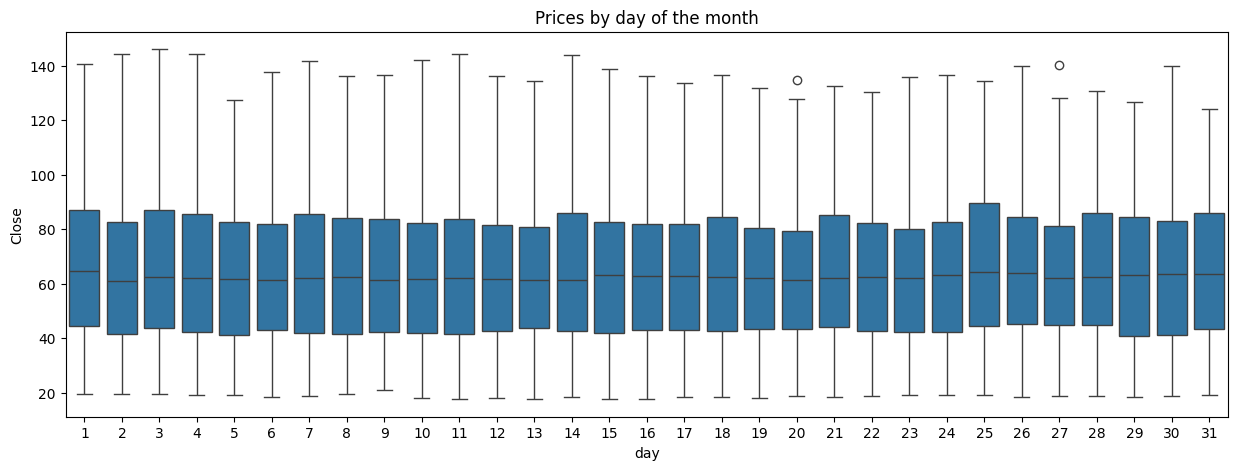

In [ ]:
fig,ax=plt.subplots(figsize=(15,5))
sns.boxplot(data=df1_final,x='day',y='Close')
ax.set_title('Prices by day of the month')

Text(0.5, 1.0, 'Prices by day of the week')

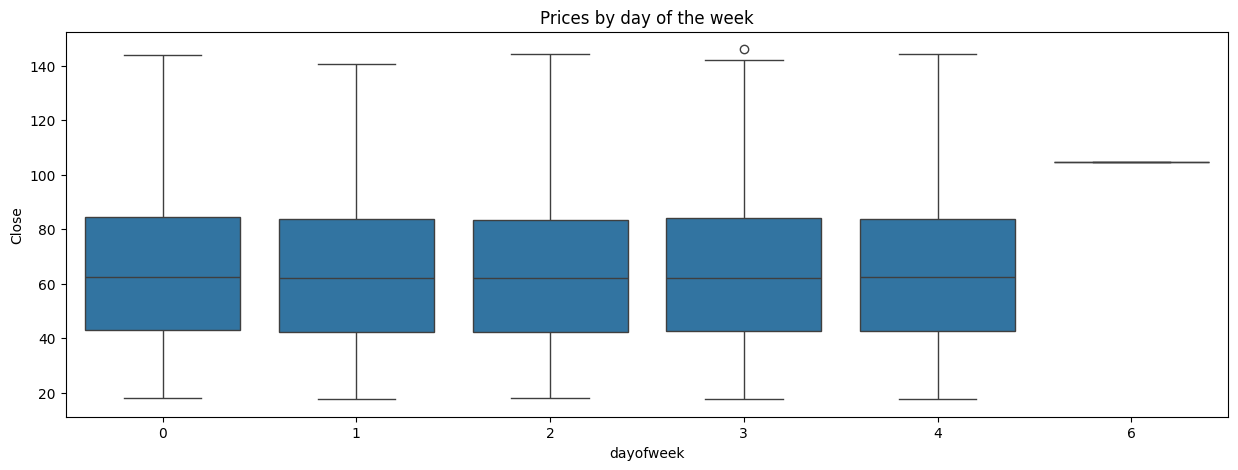

In [ ]:
fig,ax=plt.subplots(figsize=(15,5))
sns.boxplot(data=df1_final,x='dayofweek',y='Close')
ax.set_title('Prices by day of the week')

Text(0.5, 1.0, 'Prices by quarter of the year')

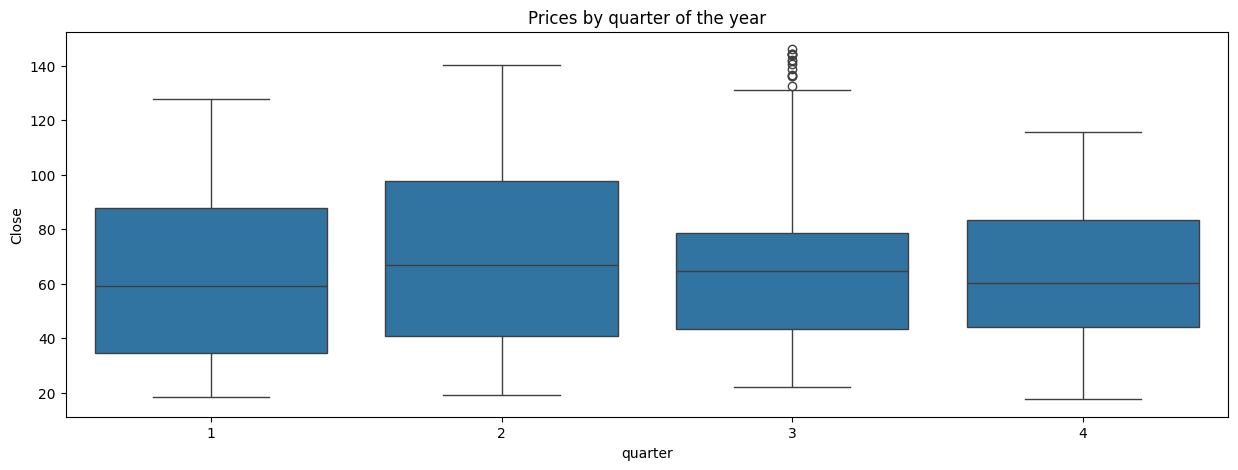

In [ ]:
fig,ax=plt.subplots(figsize=(15,5))
sns.boxplot(data=df1_final,x='quarter',y='Close')
ax.set_title('Prices by quarter of the year')

Text(0.5, 1.0, 'Prices by year')

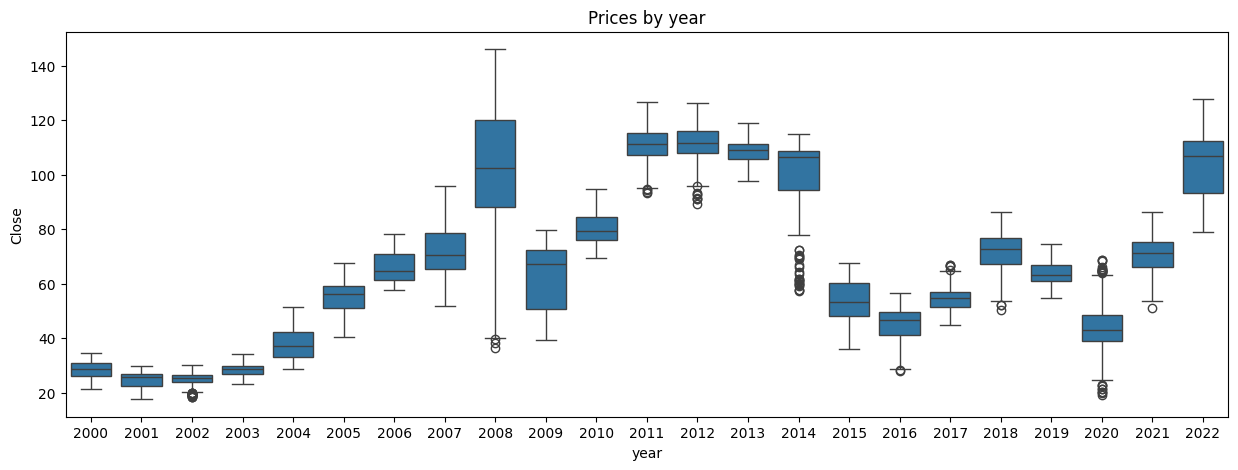

In [ ]:
fig,ax=plt.subplots(figsize=(15,5))
sns.boxplot(data=df1_final,x='year',y='Close')
ax.set_title('Prices by year')

In [ ]:
train=create_features(train)
test=create_features(test)

<ipython-input-9-9d93f1c362eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_final['day']=df1_final.index.day
<ipython-input-9-9d93f1c362eb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_final['dayofweek']= df1_final.index.dayofweek
<ipython-input-9-9d93f1c362eb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [ ]:
FEATURES=['day','dayofweek', 'quarter', 'month','year']
TARGET=['Close']

In [ ]:
df1_final['Close'] = pd.to_numeric(df1_final['Close'], errors='coerce')

In [ ]:
df1_final['Close_lag14'] = df1_final['Close'].shift(14)
df1_final['Close_lag28'] = df1_final['Close'].shift(28)

In [ ]:
df1_final['Close_rolling7'] = df1_final['Close'].rolling(window=7).mean()
df1_final['Close_rolling30'] = df1_final['Close'].rolling(window=30).mean()

In [ ]:
df1_final['dayofweek_month'] = df1_final['dayofweek']  * df1_final['quarter']

In [ ]:
df1_final['weekofyear'] = df1_final.index.isocalendar().week
df1_final['dayofyear'] = df1_final.index.dayofyear

In [ ]:
print(FEATURES)
print(TARGET)

['day', 'dayofweek', 'quarter', 'month', 'year']
['Close']


In [ ]:
X = df1_final[['day', 'dayofweek', 'quarter', 'month', 'year']]
y = df1_final['Close']

In [ ]:
X_train=train[FEATURES]
y_train=train[TARGET]

X_test=test[FEATURES]
y_test=test[TARGET]
#y_test = y_test.values.ravel()

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
       'n_estimators': [1000, 1500, 2000],
       'learning_rate': [0.01, 0.001],
       'max_depth': [3, 5, 7]
   }

# Instead of using fit_params, directly pass eval_set and verbose to the .fit method
grid_search = GridSearchCV(reg, param_grid, cv=5, scoring='neg_mean_squared_error', refit=True)

grid_search.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)

best_reg = grid_search.best_estimator

[0]	validation_0-rmse:74.44307	validation_1-rmse:61.46090
[100]	validation_0-rmse:29.00292	validation_1-rmse:17.62244


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[138]	validation_0-rmse:21.11328	validation_1-rmse:23.45186
[0]	validation_0-rmse:74.46515	validation_1-rmse:61.46090
[100]	validation_0-rmse:30.91238	validation_1-rmse:17.62244


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[139]	validation_0-rmse:23.30616	validation_1-rmse:23.60906
[0]	validation_0-rmse:74.48544	validation_1-rmse:61.46090
[100]	validation_0-rmse:31.94608	validation_1-rmse:17.62244
[138]	validation_0-rmse:24.69420	validation_1-rmse:23.47959


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.40980	validation_1-rmse:61.41437
[100]	validation_0-rmse:30.74997	validation_1-rmse:18.05470
[137]	validation_0-rmse:23.64622	validation_1-rmse:24.05159
[0]	validation_0-rmse:74.43488	validation_1-rmse:61.35106


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:28.88079	validation_1-rmse:19.91436
[127]	validation_0-rmse:22.94199	validation_1-rmse:25.40852
[0]	validation_0-rmse:74.44307	validation_1-rmse:61.46090
[100]	validation_0-rmse:29.00292	validation_1-rmse:17.62244
[138]	validation_0-rmse:21.11328	validation_1-rmse:23.45186
[0]	validation_0-rmse:74.46515	validation_1-rmse:61.46090


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:30.91238	validation_1-rmse:17.62244
[139]	validation_0-rmse:23.30616	validation_1-rmse:23.60906
[0]	validation_0-rmse:74.48544	validation_1-rmse:61.46090
[100]	validation_0-rmse:31.94608	validation_1-rmse:17.62244
[138]	validation_0-rmse:24.69420	validation_1-rmse:23.47959


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.40980	validation_1-rmse:61.41437
[100]	validation_0-rmse:30.74997	validation_1-rmse:18.05470


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[138]	validation_0-rmse:23.48223	validation_1-rmse:24.23521
[0]	validation_0-rmse:74.43488	validation_1-rmse:61.35106


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:28.88079	validation_1-rmse:19.91436
[126]	validation_0-rmse:23.14394	validation_1-rmse:25.19890
[0]	validation_0-rmse:74.44307	validation_1-rmse:61.46090


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:29.00292	validation_1-rmse:17.62244
[138]	validation_0-rmse:21.11328	validation_1-rmse:23.45186
[0]	validation_0-rmse:74.46515	validation_1-rmse:61.46090


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:30.91238	validation_1-rmse:17.62244
[138]	validation_0-rmse:23.46034	validation_1-rmse:23.45177
[0]	validation_0-rmse:74.48544	validation_1-rmse:61.46090


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:31.94608	validation_1-rmse:17.62244
[139]	validation_0-rmse:24.54073	validation_1-rmse:23.63681
[0]	validation_0-rmse:74.40980	validation_1-rmse:61.41437
[100]	validation_0-rmse:30.74997	validation_1-rmse:18.05470


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[138]	validation_0-rmse:23.48223	validation_1-rmse:24.23521
[0]	validation_0-rmse:74.43488	validation_1-rmse:61.35106
[100]	validation_0-rmse:28.88079	validation_1-rmse:19.91436
[126]	validation_0-rmse:23.14394	validation_1-rmse:25.19890
[0]	validation_0-rmse:74.43114	validation_1-rmse:61.45936


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:27.77503	validation_1-rmse:18.89153
[139]	validation_0-rmse:19.08354	validation_1-rmse:24.20857
[0]	validation_0-rmse:74.45301	validation_1-rmse:61.45936
[100]	validation_0-rmse:29.80958	validation_1-rmse:18.89153
[140]	validation_0-rmse:21.59355	validation_1-rmse:24.37057


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.47612	validation_1-rmse:61.45936
[100]	validation_0-rmse:31.42056	validation_1-rmse:18.89153


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[139]	validation_0-rmse:23.84117	validation_1-rmse:24.20857
[0]	validation_0-rmse:74.39373	validation_1-rmse:61.43074
[100]	validation_0-rmse:27.25157	validation_1-rmse:19.33188
[135]	validation_0-rmse:20.32636	validation_1-rmse:24.61842


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.42398	validation_1-rmse:61.35106
[100]	validation_0-rmse:27.90223	validation_1-rmse:19.92264
[127]	validation_0-rmse:21.73118	validation_1-rmse:26.16814
[0]	validation_0-rmse:74.43114	validation_1-rmse:61.45936


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:27.77503	validation_1-rmse:18.89153
[139]	validation_0-rmse:19.08354	validation_1-rmse:24.20857
[0]	validation_0-rmse:74.45301	validation_1-rmse:61.45936
[100]	validation_0-rmse:29.80958	validation_1-rmse:18.89153


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[140]	validation_0-rmse:21.59355	validation_1-rmse:24.37057
[0]	validation_0-rmse:74.47612	validation_1-rmse:61.45936
[100]	validation_0-rmse:31.42056	validation_1-rmse:18.89153


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[140]	validation_0-rmse:23.68586	validation_1-rmse:24.37057
[0]	validation_0-rmse:74.39373	validation_1-rmse:61.43074
[100]	validation_0-rmse:27.25157	validation_1-rmse:19.33188
[136]	validation_0-rmse:20.16389	validation_1-rmse:24.78666


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.42398	validation_1-rmse:61.35106
[100]	validation_0-rmse:27.90223	validation_1-rmse:19.92264
[126]	validation_0-rmse:21.92704	validation_1-rmse:25.93430


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.43114	validation_1-rmse:61.45936
[100]	validation_0-rmse:27.77503	validation_1-rmse:18.89153
[140]	validation_0-rmse:18.90566	validation_1-rmse:24.37057


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.45301	validation_1-rmse:61.45936
[100]	validation_0-rmse:29.80958	validation_1-rmse:18.89153


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[140]	validation_0-rmse:21.59355	validation_1-rmse:24.37057
[0]	validation_0-rmse:74.47612	validation_1-rmse:61.45936
[100]	validation_0-rmse:31.42056	validation_1-rmse:18.89153
[139]	validation_0-rmse:23.84117	validation_1-rmse:24.20857


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.39373	validation_1-rmse:61.43074
[100]	validation_0-rmse:27.25157	validation_1-rmse:19.33188
[135]	validation_0-rmse:20.32636	validation_1-rmse:24.61842


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.42398	validation_1-rmse:61.35106
[100]	validation_0-rmse:27.90223	validation_1-rmse:19.92264
[126]	validation_0-rmse:21.92704	validation_1-rmse:25.93430


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.43043	validation_1-rmse:61.45936
[100]	validation_0-rmse:27.65284	validation_1-rmse:18.91452


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[139]	validation_0-rmse:18.92048	validation_1-rmse:24.30883
[0]	validation_0-rmse:74.45119	validation_1-rmse:61.45936
[100]	validation_0-rmse:29.34305	validation_1-rmse:18.91452


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[139]	validation_0-rmse:21.20058	validation_1-rmse:24.30883
[0]	validation_0-rmse:74.47611	validation_1-rmse:61.45936
[100]	validation_0-rmse:31.33847	validation_1-rmse:18.91452
[140]	validation_0-rmse:23.62377	validation_1-rmse:24.47365


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.39713	validation_1-rmse:61.43222
[100]	validation_0-rmse:27.07321	validation_1-rmse:19.27776


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[138]	validation_0-rmse:19.82997	validation_1-rmse:24.82531
[0]	validation_0-rmse:74.42214	validation_1-rmse:61.35106
[100]	validation_0-rmse:27.28537	validation_1-rmse:19.92264


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[126]	validation_0-rmse:21.13362	validation_1-rmse:25.93430
[0]	validation_0-rmse:74.43043	validation_1-rmse:61.45936
[100]	validation_0-rmse:27.65284	validation_1-rmse:18.91452


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[140]	validation_0-rmse:18.73867	validation_1-rmse:24.47365
[0]	validation_0-rmse:74.45119	validation_1-rmse:61.45936
[100]	validation_0-rmse:29.34305	validation_1-rmse:18.91452


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[140]	validation_0-rmse:21.03337	validation_1-rmse:24.47365
[0]	validation_0-rmse:74.47611	validation_1-rmse:61.45936
[100]	validation_0-rmse:31.33847	validation_1-rmse:18.91452


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[140]	validation_0-rmse:23.62377	validation_1-rmse:24.47365
[0]	validation_0-rmse:74.39713	validation_1-rmse:61.43222
[100]	validation_0-rmse:27.07321	validation_1-rmse:19.27776


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[137]	validation_0-rmse:19.97428	validation_1-rmse:24.65941
[0]	validation_0-rmse:74.42214	validation_1-rmse:61.35106
[100]	validation_0-rmse:27.28537	validation_1-rmse:19.92264
[127]	validation_0-rmse:20.92990	validation_1-rmse:26.16814


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.43043	validation_1-rmse:61.45936
[100]	validation_0-rmse:27.65284	validation_1-rmse:18.91452


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[140]	validation_0-rmse:18.73867	validation_1-rmse:24.47365
[0]	validation_0-rmse:74.45119	validation_1-rmse:61.45936
[100]	validation_0-rmse:29.34305	validation_1-rmse:18.91452


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[140]	validation_0-rmse:21.03337	validation_1-rmse:24.47365
[0]	validation_0-rmse:74.47611	validation_1-rmse:61.45936
[100]	validation_0-rmse:31.33847	validation_1-rmse:18.91452


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[140]	validation_0-rmse:23.62377	validation_1-rmse:24.47365
[0]	validation_0-rmse:74.39713	validation_1-rmse:61.43222
[100]	validation_0-rmse:27.07321	validation_1-rmse:19.27776


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[137]	validation_0-rmse:19.97428	validation_1-rmse:24.65941
[0]	validation_0-rmse:74.42214	validation_1-rmse:61.35106
[100]	validation_0-rmse:27.28537	validation_1-rmse:19.92264


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[126]	validation_0-rmse:21.13362	validation_1-rmse:25.93430
[0]	validation_0-rmse:75.10259	validation_1-rmse:62.31396
[100]	validation_0-rmse:68.12501	validation_1-rmse:53.35396


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.81926	validation_1-rmse:45.39086
[300]	validation_0-rmse:56.12991	validation_1-rmse:38.24036
[400]	validation_0-rmse:51.00409	validation_1-rmse:31.92171
[500]	validation_0-rmse:46.38468	validation_1-rmse:26.62297
[600]	validation_0-rmse:42.22438	validation_1-rmse:22.40226
[700]	validation_0-rmse:38.47565	validation_1-rmse:19.36986
[800]	validation_0-rmse:35.10201	validation_1-rmse:17.60214
[900]	validation_0-rmse:32.06876	validation_1-rmse:17.05563
[949]	validation_0-rmse:30.69887	validation_1-rmse:17.17088
[0]	validation_0-rmse:75.10480	validation_1-rmse:62.31396
[100]	validation_0-rmse:68.35697	validation_1-rmse:53.35396


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.27852	validation_1-rmse:45.39086
[300]	validation_0-rmse:56.80657	validation_1-rmse:38.24036
[400]	validation_0-rmse:51.88601	validation_1-rmse:31.92171
[500]	validation_0-rmse:47.46633	validation_1-rmse:26.62297
[600]	validation_0-rmse:43.48889	validation_1-rmse:22.40226
[700]	validation_0-rmse:39.91282	validation_1-rmse:19.36986
[800]	validation_0-rmse:36.71553	validation_1-rmse:17.60214
[900]	validation_0-rmse:33.82370	validation_1-rmse:17.05563
[949]	validation_0-rmse:32.52094	validation_1-rmse:17.17088
[0]	validation_0-rmse:75.10683	validation_1-rmse:62.31396
[100]	validation_0-rmse:68.55066	validation_1-rmse:53.35396


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.64326	validation_1-rmse:45.39086
[300]	validation_0-rmse:57.32475	validation_1-rmse:38.24036
[400]	validation_0-rmse:52.54039	validation_1-rmse:31.92171
[500]	validation_0-rmse:48.24120	validation_1-rmse:26.62297
[600]	validation_0-rmse:44.34753	validation_1-rmse:22.40226
[700]	validation_0-rmse:40.83345	validation_1-rmse:19.36986
[800]	validation_0-rmse:37.65194	validation_1-rmse:17.60214
[900]	validation_0-rmse:34.80521	validation_1-rmse:17.05563
[950]	validation_0-rmse:33.49709	validation_1-rmse:17.17576
[0]	validation_0-rmse:75.09926	validation_1-rmse:62.30930
[100]	validation_0-rmse:67.82861	validation_1-rmse:52.91805


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.28675	validation_1-rmse:44.59656
[300]	validation_0-rmse:55.40488	validation_1-rmse:37.30718
[400]	validation_0-rmse:50.35270	validation_1-rmse:31.11047
[500]	validation_0-rmse:46.15178	validation_1-rmse:26.03939
[600]	validation_0-rmse:42.40728	validation_1-rmse:22.05730
[700]	validation_0-rmse:39.07774	validation_1-rmse:19.26286
[800]	validation_0-rmse:36.11535	validation_1-rmse:17.71596
[900]	validation_0-rmse:33.49724	validation_1-rmse:17.34381
[936]	validation_0-rmse:32.62727	validation_1-rmse:17.45543
[0]	validation_0-rmse:75.10177	validation_1-rmse:62.30296
[100]	validation_0-rmse:68.06258	validation_1-rmse:52.31374


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:10] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.71373	validation_1-rmse:43.46728
[300]	validation_0-rmse:55.99092	validation_1-rmse:35.73933
[400]	validation_0-rmse:50.83617	validation_1-rmse:29.15707
[500]	validation_0-rmse:46.20023	validation_1-rmse:23.82779
[600]	validation_0-rmse:42.03387	validation_1-rmse:19.93160
[700]	validation_0-rmse:38.28896	validation_1-rmse:17.68385
[800]	validation_0-rmse:34.91299	validation_1-rmse:17.12892
[835]	validation_0-rmse:33.81740	validation_1-rmse:17.28822
[0]	validation_0-rmse:75.10259	validation_1-rmse:62.31396
[100]	validation_0-rmse:68.12501	validation_1-rmse:53.35396


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.81926	validation_1-rmse:45.39086
[300]	validation_0-rmse:56.12991	validation_1-rmse:38.24036
[400]	validation_0-rmse:51.00409	validation_1-rmse:31.92171
[500]	validation_0-rmse:46.38468	validation_1-rmse:26.62297
[600]	validation_0-rmse:42.22438	validation_1-rmse:22.40226
[700]	validation_0-rmse:38.47565	validation_1-rmse:19.36986
[800]	validation_0-rmse:35.10201	validation_1-rmse:17.60214
[900]	validation_0-rmse:32.06876	validation_1-rmse:17.05563
[950]	validation_0-rmse:30.67164	validation_1-rmse:17.17576
[0]	validation_0-rmse:75.10480	validation_1-rmse:62.31396
[100]	validation_0-rmse:68.35697	validation_1-rmse:53.35396


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:12] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.27852	validation_1-rmse:45.39086
[300]	validation_0-rmse:56.80657	validation_1-rmse:38.24036
[400]	validation_0-rmse:51.88601	validation_1-rmse:31.92171
[500]	validation_0-rmse:47.46633	validation_1-rmse:26.62297
[600]	validation_0-rmse:43.48889	validation_1-rmse:22.40226
[700]	validation_0-rmse:39.91282	validation_1-rmse:19.36986
[800]	validation_0-rmse:36.71553	validation_1-rmse:17.60214
[900]	validation_0-rmse:33.82370	validation_1-rmse:17.05563
[950]	validation_0-rmse:32.49505	validation_1-rmse:17.17576
[0]	validation_0-rmse:75.10683	validation_1-rmse:62.31396
[100]	validation_0-rmse:68.55066	validation_1-rmse:53.35396


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.64326	validation_1-rmse:45.39086
[300]	validation_0-rmse:57.32475	validation_1-rmse:38.24036
[400]	validation_0-rmse:52.54039	validation_1-rmse:31.92171
[500]	validation_0-rmse:48.24120	validation_1-rmse:26.62297
[600]	validation_0-rmse:44.34753	validation_1-rmse:22.40226
[700]	validation_0-rmse:40.83345	validation_1-rmse:19.36986
[800]	validation_0-rmse:37.65194	validation_1-rmse:17.60214
[900]	validation_0-rmse:34.80521	validation_1-rmse:17.05563
[950]	validation_0-rmse:33.49709	validation_1-rmse:17.17576
[0]	validation_0-rmse:75.09926	validation_1-rmse:62.30930
[100]	validation_0-rmse:67.82861	validation_1-rmse:52.91805


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.28675	validation_1-rmse:44.59656
[300]	validation_0-rmse:55.40488	validation_1-rmse:37.30718
[400]	validation_0-rmse:50.35270	validation_1-rmse:31.11047
[500]	validation_0-rmse:46.15178	validation_1-rmse:26.03939
[600]	validation_0-rmse:42.40728	validation_1-rmse:22.05730
[700]	validation_0-rmse:39.07774	validation_1-rmse:19.26286
[800]	validation_0-rmse:36.11535	validation_1-rmse:17.71596
[900]	validation_0-rmse:33.49724	validation_1-rmse:17.34381
[936]	validation_0-rmse:32.62727	validation_1-rmse:17.45543
[0]	validation_0-rmse:75.10177	validation_1-rmse:62.30296
[100]	validation_0-rmse:68.06258	validation_1-rmse:52.31374


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.71373	validation_1-rmse:43.46728
[300]	validation_0-rmse:55.99092	validation_1-rmse:35.73933
[400]	validation_0-rmse:50.83617	validation_1-rmse:29.15707
[500]	validation_0-rmse:46.20023	validation_1-rmse:23.82779
[600]	validation_0-rmse:42.03387	validation_1-rmse:19.93160
[700]	validation_0-rmse:38.28896	validation_1-rmse:17.68385
[800]	validation_0-rmse:34.91299	validation_1-rmse:17.12892
[835]	validation_0-rmse:33.81740	validation_1-rmse:17.28822
[0]	validation_0-rmse:75.10259	validation_1-rmse:62.31396
[100]	validation_0-rmse:68.12501	validation_1-rmse:53.35396


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.81926	validation_1-rmse:45.39086
[300]	validation_0-rmse:56.12991	validation_1-rmse:38.24036
[400]	validation_0-rmse:51.00409	validation_1-rmse:31.92171
[500]	validation_0-rmse:46.38468	validation_1-rmse:26.62297
[600]	validation_0-rmse:42.22438	validation_1-rmse:22.40226
[700]	validation_0-rmse:38.47565	validation_1-rmse:19.36986
[800]	validation_0-rmse:35.10201	validation_1-rmse:17.60214
[900]	validation_0-rmse:32.06876	validation_1-rmse:17.05563
[950]	validation_0-rmse:30.67164	validation_1-rmse:17.17576
[0]	validation_0-rmse:75.10480	validation_1-rmse:62.31396
[100]	validation_0-rmse:68.35697	validation_1-rmse:53.35396


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.27852	validation_1-rmse:45.39086
[300]	validation_0-rmse:56.80657	validation_1-rmse:38.24036
[400]	validation_0-rmse:51.88601	validation_1-rmse:31.92171
[500]	validation_0-rmse:47.46633	validation_1-rmse:26.62297
[600]	validation_0-rmse:43.48889	validation_1-rmse:22.40226
[700]	validation_0-rmse:39.91282	validation_1-rmse:19.36986
[800]	validation_0-rmse:36.71553	validation_1-rmse:17.60214
[900]	validation_0-rmse:33.82370	validation_1-rmse:17.05563
[950]	validation_0-rmse:32.49505	validation_1-rmse:17.17576
[0]	validation_0-rmse:75.10683	validation_1-rmse:62.31396


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:68.55066	validation_1-rmse:53.35396
[200]	validation_0-rmse:62.64326	validation_1-rmse:45.39086
[300]	validation_0-rmse:57.32475	validation_1-rmse:38.24036
[400]	validation_0-rmse:52.54039	validation_1-rmse:31.92171
[500]	validation_0-rmse:48.24120	validation_1-rmse:26.62297
[600]	validation_0-rmse:44.34753	validation_1-rmse:22.40226
[700]	validation_0-rmse:40.83345	validation_1-rmse:19.36986
[800]	validation_0-rmse:37.65194	validation_1-rmse:17.60214
[900]	validation_0-rmse:34.80521	validation_1-rmse:17.05563
[949]	validation_0-rmse:33.52310	validation_1-rmse:17.17088
[0]	validation_0-rmse:75.09926	validation_1-rmse:62.30930
[100]	validation_0-rmse:67.82861	validation_1-rmse:52.91805


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.28675	validation_1-rmse:44.59656
[300]	validation_0-rmse:55.40488	validation_1-rmse:37.30718
[400]	validation_0-rmse:50.35270	validation_1-rmse:31.11047
[500]	validation_0-rmse:46.15178	validation_1-rmse:26.03939
[600]	validation_0-rmse:42.40728	validation_1-rmse:22.05730
[700]	validation_0-rmse:39.07774	validation_1-rmse:19.26286
[800]	validation_0-rmse:36.11535	validation_1-rmse:17.71596
[900]	validation_0-rmse:33.49724	validation_1-rmse:17.34381
[937]	validation_0-rmse:32.60920	validation_1-rmse:17.45945
[0]	validation_0-rmse:75.10177	validation_1-rmse:62.30296
[100]	validation_0-rmse:68.06258	validation_1-rmse:52.31374


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.71373	validation_1-rmse:43.46728
[300]	validation_0-rmse:55.99092	validation_1-rmse:35.73933
[400]	validation_0-rmse:50.83617	validation_1-rmse:29.15707
[500]	validation_0-rmse:46.20023	validation_1-rmse:23.82779
[600]	validation_0-rmse:42.03387	validation_1-rmse:19.93160
[700]	validation_0-rmse:38.28896	validation_1-rmse:17.68385
[800]	validation_0-rmse:34.91299	validation_1-rmse:17.12892
[835]	validation_0-rmse:33.81740	validation_1-rmse:17.28822
[0]	validation_0-rmse:75.10141	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.01887	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.61314	validation_1-rmse:45.41080
[300]	validation_0-rmse:55.82007	validation_1-rmse:38.45458
[400]	validation_0-rmse:50.58410	validation_1-rmse:32.46840
[500]	validation_0-rmse:45.88685	validation_1-rmse:27.47781
[600]	validation_0-rmse:41.59653	validation_1-rmse:23.53659
[700]	validation_0-rmse:37.71037	validation_1-rmse:20.71554
[800]	validation_0-rmse:34.19787	validation_1-rmse:19.05706
[900]	validation_0-rmse:31.01631	validation_1-rmse:18.47813
[961]	validation_0-rmse:29.22700	validation_1-rmse:18.58200
[0]	validation_0-rmse:75.10359	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.23371	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.03254	validation_1-rmse:45.41080
[300]	validation_0-rmse:56.45965	validation_1-rmse:38.45458
[400]	validation_0-rmse:51.43904	validation_1-rmse:32.46840
[500]	validation_0-rmse:46.91745	validation_1-rmse:27.47781
[600]	validation_0-rmse:42.84731	validation_1-rmse:23.53659
[700]	validation_0-rmse:39.18143	validation_1-rmse:20.71554
[800]	validation_0-rmse:35.84957	validation_1-rmse:19.05706
[900]	validation_0-rmse:32.85155	validation_1-rmse:18.47813
[960]	validation_0-rmse:31.20167	validation_1-rmse:18.57794
[0]	validation_0-rmse:75.10590	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.45914	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.46557	validation_1-rmse:45.41080
[300]	validation_0-rmse:57.06499	validation_1-rmse:38.45458
[400]	validation_0-rmse:52.20258	validation_1-rmse:32.46840
[500]	validation_0-rmse:47.82895	validation_1-rmse:27.47781
[600]	validation_0-rmse:43.89981	validation_1-rmse:23.53659
[700]	validation_0-rmse:40.38136	validation_1-rmse:20.71554
[800]	validation_0-rmse:37.20856	validation_1-rmse:19.05706
[900]	validation_0-rmse:34.32815	validation_1-rmse:18.47813
[961]	validation_0-rmse:32.72067	validation_1-rmse:18.58200
[0]	validation_0-rmse:75.09765	validation_1-rmse:62.31093
[100]	validation_0-rmse:67.67027	validation_1-rmse:53.08090


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:60.97818	validation_1-rmse:44.91914
[300]	validation_0-rmse:54.95659	validation_1-rmse:37.79076
[400]	validation_0-rmse:49.54963	validation_1-rmse:31.71490
[500]	validation_0-rmse:44.69505	validation_1-rmse:26.71306
[600]	validation_0-rmse:40.34748	validation_1-rmse:22.85019
[700]	validation_0-rmse:36.54552	validation_1-rmse:20.20676
[800]	validation_0-rmse:33.19893	validation_1-rmse:18.82215
[900]	validation_0-rmse:30.23597	validation_1-rmse:18.57853
[924]	validation_0-rmse:29.58109	validation_1-rmse:18.65939
[0]	validation_0-rmse:75.10069	validation_1-rmse:62.30296
[100]	validation_0-rmse:67.95188	validation_1-rmse:52.31374


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.49391	validation_1-rmse:43.46728
[300]	validation_0-rmse:55.68053	validation_1-rmse:35.73933
[400]	validation_0-rmse:50.43649	validation_1-rmse:29.15707
[500]	validation_0-rmse:45.70899	validation_1-rmse:23.82779
[600]	validation_0-rmse:41.44725	validation_1-rmse:19.93160
[700]	validation_0-rmse:37.60901	validation_1-rmse:17.68385
[800]	validation_0-rmse:34.15629	validation_1-rmse:17.12269
[836]	validation_0-rmse:32.99927	validation_1-rmse:17.27831
[0]	validation_0-rmse:75.10141	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.01887	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.61314	validation_1-rmse:45.41080
[300]	validation_0-rmse:55.82007	validation_1-rmse:38.45458
[400]	validation_0-rmse:50.58410	validation_1-rmse:32.46840
[500]	validation_0-rmse:45.88685	validation_1-rmse:27.47781
[600]	validation_0-rmse:41.59653	validation_1-rmse:23.53659
[700]	validation_0-rmse:37.71037	validation_1-rmse:20.71554
[800]	validation_0-rmse:34.19787	validation_1-rmse:19.05706
[900]	validation_0-rmse:31.01631	validation_1-rmse:18.47813
[960]	validation_0-rmse:29.25545	validation_1-rmse:18.57794
[0]	validation_0-rmse:75.10359	validation_1-rmse:62.31379


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:32] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:68.23371	validation_1-rmse:53.34951
[200]	validation_0-rmse:62.03254	validation_1-rmse:45.41080
[300]	validation_0-rmse:56.45965	validation_1-rmse:38.45458
[400]	validation_0-rmse:51.43904	validation_1-rmse:32.46840
[500]	validation_0-rmse:46.91745	validation_1-rmse:27.47781
[600]	validation_0-rmse:42.84731	validation_1-rmse:23.53659
[700]	validation_0-rmse:39.18143	validation_1-rmse:20.71554
[800]	validation_0-rmse:35.84957	validation_1-rmse:19.05706
[900]	validation_0-rmse:32.85155	validation_1-rmse:18.47813
[961]	validation_0-rmse:31.17431	validation_1-rmse:18.58200
[0]	validation_0-rmse:75.10590	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.45914	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.46557	validation_1-rmse:45.41080
[300]	validation_0-rmse:57.06499	validation_1-rmse:38.45458
[400]	validation_0-rmse:52.20258	validation_1-rmse:32.46840
[500]	validation_0-rmse:47.82895	validation_1-rmse:27.47781
[600]	validation_0-rmse:43.89981	validation_1-rmse:23.53659
[700]	validation_0-rmse:40.38136	validation_1-rmse:20.71554
[800]	validation_0-rmse:37.20856	validation_1-rmse:19.05706
[900]	validation_0-rmse:34.32815	validation_1-rmse:18.47813
[960]	validation_0-rmse:32.74576	validation_1-rmse:18.57794
[0]	validation_0-rmse:75.09765	validation_1-rmse:62.31093
[100]	validation_0-rmse:67.67027	validation_1-rmse:53.08090


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:60.97818	validation_1-rmse:44.91914
[300]	validation_0-rmse:54.95659	validation_1-rmse:37.79076
[400]	validation_0-rmse:49.54963	validation_1-rmse:31.71490
[500]	validation_0-rmse:44.69505	validation_1-rmse:26.71306
[600]	validation_0-rmse:40.34748	validation_1-rmse:22.85019
[700]	validation_0-rmse:36.54552	validation_1-rmse:20.20676
[800]	validation_0-rmse:33.19893	validation_1-rmse:18.82215
[900]	validation_0-rmse:30.23597	validation_1-rmse:18.57853
[924]	validation_0-rmse:29.58109	validation_1-rmse:18.65939
[0]	validation_0-rmse:75.10069	validation_1-rmse:62.30296
[100]	validation_0-rmse:67.95188	validation_1-rmse:52.31374


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.49391	validation_1-rmse:43.46728
[300]	validation_0-rmse:55.68053	validation_1-rmse:35.73933
[400]	validation_0-rmse:50.43649	validation_1-rmse:29.15707
[500]	validation_0-rmse:45.70899	validation_1-rmse:23.82779
[600]	validation_0-rmse:41.44725	validation_1-rmse:19.93160
[700]	validation_0-rmse:37.60901	validation_1-rmse:17.68385
[800]	validation_0-rmse:34.15629	validation_1-rmse:17.12269
[837]	validation_0-rmse:32.96787	validation_1-rmse:17.28503
[0]	validation_0-rmse:75.10141	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.01887	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:39] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.61314	validation_1-rmse:45.41080
[300]	validation_0-rmse:55.82007	validation_1-rmse:38.45458
[400]	validation_0-rmse:50.58410	validation_1-rmse:32.46840
[500]	validation_0-rmse:45.88685	validation_1-rmse:27.47781
[600]	validation_0-rmse:41.59653	validation_1-rmse:23.53659
[700]	validation_0-rmse:37.71037	validation_1-rmse:20.71554
[800]	validation_0-rmse:34.19787	validation_1-rmse:19.05706
[900]	validation_0-rmse:31.01631	validation_1-rmse:18.47813
[960]	validation_0-rmse:29.25545	validation_1-rmse:18.57794
[0]	validation_0-rmse:75.10359	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.23371	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.03254	validation_1-rmse:45.41080
[300]	validation_0-rmse:56.45965	validation_1-rmse:38.45458
[400]	validation_0-rmse:51.43904	validation_1-rmse:32.46840
[500]	validation_0-rmse:46.91745	validation_1-rmse:27.47781
[600]	validation_0-rmse:42.84731	validation_1-rmse:23.53659
[700]	validation_0-rmse:39.18143	validation_1-rmse:20.71554
[800]	validation_0-rmse:35.84957	validation_1-rmse:19.05706
[900]	validation_0-rmse:32.85155	validation_1-rmse:18.47813
[960]	validation_0-rmse:31.20167	validation_1-rmse:18.57794
[0]	validation_0-rmse:75.10590	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.45914	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.46557	validation_1-rmse:45.41080
[300]	validation_0-rmse:57.06499	validation_1-rmse:38.45458
[400]	validation_0-rmse:52.20258	validation_1-rmse:32.46840
[500]	validation_0-rmse:47.82895	validation_1-rmse:27.47781
[600]	validation_0-rmse:43.89981	validation_1-rmse:23.53659
[700]	validation_0-rmse:40.38136	validation_1-rmse:20.71554
[800]	validation_0-rmse:37.20856	validation_1-rmse:19.05706
[900]	validation_0-rmse:34.32815	validation_1-rmse:18.47813
[961]	validation_0-rmse:32.72067	validation_1-rmse:18.58200
[0]	validation_0-rmse:75.09765	validation_1-rmse:62.31093
[100]	validation_0-rmse:67.67027	validation_1-rmse:53.08090


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:60.97818	validation_1-rmse:44.91914
[300]	validation_0-rmse:54.95659	validation_1-rmse:37.79076
[400]	validation_0-rmse:49.54963	validation_1-rmse:31.71490
[500]	validation_0-rmse:44.69505	validation_1-rmse:26.71306
[600]	validation_0-rmse:40.34748	validation_1-rmse:22.85019
[700]	validation_0-rmse:36.54552	validation_1-rmse:20.20676
[800]	validation_0-rmse:33.19893	validation_1-rmse:18.82215
[900]	validation_0-rmse:30.23597	validation_1-rmse:18.57853
[925]	validation_0-rmse:29.55266	validation_1-rmse:18.66367
[0]	validation_0-rmse:75.10069	validation_1-rmse:62.30296
[100]	validation_0-rmse:67.95188	validation_1-rmse:52.31374


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.49391	validation_1-rmse:43.46728
[300]	validation_0-rmse:55.68053	validation_1-rmse:35.73933
[400]	validation_0-rmse:50.43649	validation_1-rmse:29.15707
[500]	validation_0-rmse:45.70899	validation_1-rmse:23.82779
[600]	validation_0-rmse:41.44725	validation_1-rmse:19.93160
[700]	validation_0-rmse:37.60901	validation_1-rmse:17.68385
[800]	validation_0-rmse:34.15629	validation_1-rmse:17.12269
[836]	validation_0-rmse:32.99927	validation_1-rmse:17.27831
[0]	validation_0-rmse:75.10134	validation_1-rmse:62.31379


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:68.01134	validation_1-rmse:53.34951
[200]	validation_0-rmse:61.59614	validation_1-rmse:45.41080
[300]	validation_0-rmse:55.79064	validation_1-rmse:38.45458
[400]	validation_0-rmse:50.53772	validation_1-rmse:32.46840
[500]	validation_0-rmse:45.78525	validation_1-rmse:27.47781
[600]	validation_0-rmse:41.48601	validation_1-rmse:23.53659
[700]	validation_0-rmse:37.59723	validation_1-rmse:20.71554
[800]	validation_0-rmse:34.08011	validation_1-rmse:19.05706
[900]	validation_0-rmse:30.89854	validation_1-rmse:18.47903
[958]	validation_0-rmse:29.19430	validation_1-rmse:18.57796
[0]	validation_0-rmse:75.10341	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.21434	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.98963	validation_1-rmse:45.41080
[300]	validation_0-rmse:56.36323	validation_1-rmse:38.45458
[400]	validation_0-rmse:51.27832	validation_1-rmse:32.46840
[500]	validation_0-rmse:46.68819	validation_1-rmse:27.47781
[600]	validation_0-rmse:42.54694	validation_1-rmse:23.53659
[700]	validation_0-rmse:38.81222	validation_1-rmse:20.71554
[800]	validation_0-rmse:35.44679	validation_1-rmse:19.05706
[900]	validation_0-rmse:32.41628	validation_1-rmse:18.47903
[959]	validation_0-rmse:30.77265	validation_1-rmse:18.58193
[0]	validation_0-rmse:75.10590	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.45892	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.46507	validation_1-rmse:45.41080
[300]	validation_0-rmse:57.06404	validation_1-rmse:38.45458
[400]	validation_0-rmse:52.20102	validation_1-rmse:32.46840
[500]	validation_0-rmse:47.82656	validation_1-rmse:27.47781
[600]	validation_0-rmse:43.89643	validation_1-rmse:23.53659
[700]	validation_0-rmse:40.35269	validation_1-rmse:20.71554
[800]	validation_0-rmse:37.13588	validation_1-rmse:19.05706
[900]	validation_0-rmse:34.24632	validation_1-rmse:18.47903
[958]	validation_0-rmse:32.71192	validation_1-rmse:18.57796
[0]	validation_0-rmse:75.09799	validation_1-rmse:62.31108
[100]	validation_0-rmse:67.70345	validation_1-rmse:53.09611


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.04238	validation_1-rmse:44.95083
[300]	validation_0-rmse:55.04893	validation_1-rmse:37.84338
[400]	validation_0-rmse:49.63495	validation_1-rmse:31.90332
[500]	validation_0-rmse:44.78133	validation_1-rmse:27.01450
[600]	validation_0-rmse:40.45066	validation_1-rmse:23.19899
[700]	validation_0-rmse:36.58445	validation_1-rmse:20.54147
[800]	validation_0-rmse:33.14490	validation_1-rmse:19.06795
[900]	validation_0-rmse:30.09707	validation_1-rmse:18.68194
[939]	validation_0-rmse:29.00785	validation_1-rmse:18.78012
[0]	validation_0-rmse:75.10051	validation_1-rmse:62.30296
[100]	validation_0-rmse:67.93221	validation_1-rmse:52.31374


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.44819	validation_1-rmse:43.46728
[300]	validation_0-rmse:55.58354	validation_1-rmse:35.73933
[400]	validation_0-rmse:50.28038	validation_1-rmse:29.15707
[500]	validation_0-rmse:45.48875	validation_1-rmse:23.82779
[600]	validation_0-rmse:41.15853	validation_1-rmse:19.93160
[700]	validation_0-rmse:37.24689	validation_1-rmse:17.68385
[800]	validation_0-rmse:33.71520	validation_1-rmse:17.12269
[836]	validation_0-rmse:32.52982	validation_1-rmse:17.27831
[0]	validation_0-rmse:75.10134	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.01134	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.59614	validation_1-rmse:45.41080
[300]	validation_0-rmse:55.79064	validation_1-rmse:38.45458
[400]	validation_0-rmse:50.53772	validation_1-rmse:32.46840
[500]	validation_0-rmse:45.78525	validation_1-rmse:27.47781
[600]	validation_0-rmse:41.48601	validation_1-rmse:23.53659
[700]	validation_0-rmse:37.59723	validation_1-rmse:20.71554
[800]	validation_0-rmse:34.08011	validation_1-rmse:19.05706
[900]	validation_0-rmse:30.89854	validation_1-rmse:18.47903
[959]	validation_0-rmse:29.16578	validation_1-rmse:18.58193
[0]	validation_0-rmse:75.10341	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.21434	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.98963	validation_1-rmse:45.41080
[300]	validation_0-rmse:56.36323	validation_1-rmse:38.45458
[400]	validation_0-rmse:51.27832	validation_1-rmse:32.46840
[500]	validation_0-rmse:46.68819	validation_1-rmse:27.47781
[600]	validation_0-rmse:42.54694	validation_1-rmse:23.53659
[700]	validation_0-rmse:38.81222	validation_1-rmse:20.71554
[800]	validation_0-rmse:35.44679	validation_1-rmse:19.05706
[900]	validation_0-rmse:32.41628	validation_1-rmse:18.47903
[959]	validation_0-rmse:30.77265	validation_1-rmse:18.58193
[0]	validation_0-rmse:75.10590	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.45892	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.46507	validation_1-rmse:45.41080
[300]	validation_0-rmse:57.06404	validation_1-rmse:38.45458
[400]	validation_0-rmse:52.20102	validation_1-rmse:32.46840
[500]	validation_0-rmse:47.82656	validation_1-rmse:27.47781
[600]	validation_0-rmse:43.89643	validation_1-rmse:23.53659
[700]	validation_0-rmse:40.35269	validation_1-rmse:20.71554
[800]	validation_0-rmse:37.13588	validation_1-rmse:19.05706
[900]	validation_0-rmse:34.24632	validation_1-rmse:18.47903
[958]	validation_0-rmse:32.71192	validation_1-rmse:18.57796
[0]	validation_0-rmse:75.09799	validation_1-rmse:62.31108
[100]	validation_0-rmse:67.70345	validation_1-rmse:53.09611


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.04238	validation_1-rmse:44.95083
[300]	validation_0-rmse:55.04893	validation_1-rmse:37.84338
[400]	validation_0-rmse:49.63495	validation_1-rmse:31.90332
[500]	validation_0-rmse:44.78133	validation_1-rmse:27.01450
[600]	validation_0-rmse:40.45066	validation_1-rmse:23.19899
[700]	validation_0-rmse:36.58445	validation_1-rmse:20.54147
[800]	validation_0-rmse:33.14490	validation_1-rmse:19.06795
[900]	validation_0-rmse:30.09707	validation_1-rmse:18.68194
[939]	validation_0-rmse:29.00785	validation_1-rmse:18.78012
[0]	validation_0-rmse:75.10051	validation_1-rmse:62.30296
[100]	validation_0-rmse:67.93221	validation_1-rmse:52.31374


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.44819	validation_1-rmse:43.46728
[300]	validation_0-rmse:55.58354	validation_1-rmse:35.73933
[400]	validation_0-rmse:50.28038	validation_1-rmse:29.15707
[500]	validation_0-rmse:45.48875	validation_1-rmse:23.82779
[600]	validation_0-rmse:41.15853	validation_1-rmse:19.93160
[700]	validation_0-rmse:37.24689	validation_1-rmse:17.68385
[800]	validation_0-rmse:33.71520	validation_1-rmse:17.12269
[837]	validation_0-rmse:32.49751	validation_1-rmse:17.28503
[0]	validation_0-rmse:75.10134	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.01134	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.59614	validation_1-rmse:45.41080
[300]	validation_0-rmse:55.79064	validation_1-rmse:38.45458
[400]	validation_0-rmse:50.53772	validation_1-rmse:32.46840
[500]	validation_0-rmse:45.78525	validation_1-rmse:27.47781
[600]	validation_0-rmse:41.48601	validation_1-rmse:23.53659
[700]	validation_0-rmse:37.59723	validation_1-rmse:20.71554
[800]	validation_0-rmse:34.08011	validation_1-rmse:19.05706
[900]	validation_0-rmse:30.89854	validation_1-rmse:18.47903
[958]	validation_0-rmse:29.19430	validation_1-rmse:18.57796
[0]	validation_0-rmse:75.10341	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.21434	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.98963	validation_1-rmse:45.41080
[300]	validation_0-rmse:56.36323	validation_1-rmse:38.45458
[400]	validation_0-rmse:51.27832	validation_1-rmse:32.46840
[500]	validation_0-rmse:46.68819	validation_1-rmse:27.47781
[600]	validation_0-rmse:42.54694	validation_1-rmse:23.53659
[700]	validation_0-rmse:38.81222	validation_1-rmse:20.71554
[800]	validation_0-rmse:35.44679	validation_1-rmse:19.05706
[900]	validation_0-rmse:32.41628	validation_1-rmse:18.47903
[958]	validation_0-rmse:30.79968	validation_1-rmse:18.57796
[0]	validation_0-rmse:75.10590	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.45892	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.46507	validation_1-rmse:45.41080
[300]	validation_0-rmse:57.06404	validation_1-rmse:38.45458
[400]	validation_0-rmse:52.20102	validation_1-rmse:32.46840
[500]	validation_0-rmse:47.82656	validation_1-rmse:27.47781
[600]	validation_0-rmse:43.89643	validation_1-rmse:23.53659
[700]	validation_0-rmse:40.35269	validation_1-rmse:20.71554
[800]	validation_0-rmse:37.13588	validation_1-rmse:19.05706
[900]	validation_0-rmse:34.24632	validation_1-rmse:18.47903
[958]	validation_0-rmse:32.71192	validation_1-rmse:18.57796
[0]	validation_0-rmse:75.09799	validation_1-rmse:62.31108
[100]	validation_0-rmse:67.70345	validation_1-rmse:53.09611


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.04238	validation_1-rmse:44.95083
[300]	validation_0-rmse:55.04893	validation_1-rmse:37.84338
[400]	validation_0-rmse:49.63495	validation_1-rmse:31.90332
[500]	validation_0-rmse:44.78133	validation_1-rmse:27.01450
[600]	validation_0-rmse:40.45066	validation_1-rmse:23.19899
[700]	validation_0-rmse:36.58445	validation_1-rmse:20.54147
[800]	validation_0-rmse:33.14490	validation_1-rmse:19.06795
[900]	validation_0-rmse:30.09707	validation_1-rmse:18.68194
[938]	validation_0-rmse:29.03502	validation_1-rmse:18.77601
[0]	validation_0-rmse:75.10051	validation_1-rmse:62.30296
[100]	validation_0-rmse:67.93221	validation_1-rmse:52.31374


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.44819	validation_1-rmse:43.46728
[300]	validation_0-rmse:55.58354	validation_1-rmse:35.73933
[400]	validation_0-rmse:50.28038	validation_1-rmse:29.15707
[500]	validation_0-rmse:45.48875	validation_1-rmse:23.82779
[600]	validation_0-rmse:41.15853	validation_1-rmse:19.93160
[700]	validation_0-rmse:37.24689	validation_1-rmse:17.68385
[800]	validation_0-rmse:33.71520	validation_1-rmse:17.12269
[837]	validation_0-rmse:32.49751	validation_1-rmse:17.28503
[0]	validation_0-rmse:75.10147	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.02329	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:12] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.61811	validation_1-rmse:45.41080
[300]	validation_0-rmse:55.82180	validation_1-rmse:38.45458
[400]	validation_0-rmse:50.57686	validation_1-rmse:32.46840
[500]	validation_0-rmse:45.83104	validation_1-rmse:27.47781
[600]	validation_0-rmse:41.53712	validation_1-rmse:23.53659
[700]	validation_0-rmse:37.65239	validation_1-rmse:20.71554
[800]	validation_0-rmse:34.13841	validation_1-rmse:19.05706
[900]	validation_0-rmse:30.95867	validation_1-rmse:18.47903
[959]	validation_0-rmse:29.22619	validation_1-rmse:18.58193


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator'

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
       'n_estimators': [1000, 1500, 2000],
       'learning_rate': [0.01, 0.001],
       'max_depth': [3, 5, 7]
   }

# Instead of using fit_params, directly pass eval_set and verbose to the .fit method
grid_search = GridSearchCV(reg, param_grid, cv=5, scoring='neg_mean_squared_error', refit=True)

# Check if y_train and y_test are DataFrames and convert to Series if necessary
if isinstance(y_train, pd.DataFrame):
    y_train = y_train['Close']  # Assuming 'Close' is the target column
if isinstance(y_test, pd.DataFrame):
    y_test = y_test['Close']  # Assuming 'Close' is the target column

try:
    grid_search.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_test, y_test)],
                    verbose=100)
    best_reg = grid_search.best_estimator_  # Access best_estimator_
except ValueError as e:
    print(f"Error during GridSearchCV fitting: {e}")
    # Handle the error, e.g., check your data and hyperparameters

[0]	validation_0-rmse:74.44307	validation_1-rmse:61.46090
[100]	validation_0-rmse:29.00292	validation_1-rmse:17.62244
[139]	validation_0-rmse:20.93684	validation_1-rmse:23.61306


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.46515	validation_1-rmse:61.46090
[100]	validation_0-rmse:30.91238	validation_1-rmse:17.62244
[138]	validation_0-rmse:23.46034	validation_1-rmse:23.45177


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.48544	validation_1-rmse:61.46090
[100]	validation_0-rmse:31.94608	validation_1-rmse:17.62244
[139]	validation_0-rmse:24.54073	validation_1-rmse:23.63681


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.40980	validation_1-rmse:61.41437
[100]	validation_0-rmse:30.74997	validation_1-rmse:18.05470
[138]	validation_0-rmse:23.48223	validation_1-rmse:24.23521


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.43488	validation_1-rmse:61.35106
[100]	validation_0-rmse:28.88079	validation_1-rmse:19.91436
[127]	validation_0-rmse:22.94199	validation_1-rmse:25.40852
[0]	validation_0-rmse:74.44307	validation_1-rmse:61.46090
[100]	validation_0-rmse:29.00292	validation_1-rmse:17.62244
[139]	validation_0-rmse:20.93684	validation_1-rmse:23.61306


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.46515	validation_1-rmse:61.46090
[100]	validation_0-rmse:30.91238	validation_1-rmse:17.62244
[139]	validation_0-rmse:23.30616	validation_1-rmse:23.60906
[0]	validation_0-rmse:74.48544	validation_1-rmse:61.46090


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:31.94608	validation_1-rmse:17.62244
[138]	validation_0-rmse:24.69420	validation_1-rmse:23.47959
[0]	validation_0-rmse:74.40980	validation_1-rmse:61.41437
[100]	validation_0-rmse:30.74997	validation_1-rmse:18.05470
[137]	validation_0-rmse:23.64622	validation_1-rmse:24.05159


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.43488	validation_1-rmse:61.35106
[100]	validation_0-rmse:28.88079	validation_1-rmse:19.91436
[127]	validation_0-rmse:22.94199	validation_1-rmse:25.40852
[0]	validation_0-rmse:74.44307	validation_1-rmse:61.46090


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:29.00292	validation_1-rmse:17.62244
[139]	validation_0-rmse:20.93684	validation_1-rmse:23.61306
[0]	validation_0-rmse:74.46515	validation_1-rmse:61.46090
[100]	validation_0-rmse:30.91238	validation_1-rmse:17.62244
[139]	validation_0-rmse:23.30616	validation_1-rmse:23.60906
[0]	validation_0-rmse:74.48544	validation_1-rmse:61.46090


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:31.94608	validation_1-rmse:17.62244
[139]	validation_0-rmse:24.54073	validation_1-rmse:23.63681
[0]	validation_0-rmse:74.40980	validation_1-rmse:61.41437
[100]	validation_0-rmse:30.74997	validation_1-rmse:18.05470
[138]	validation_0-rmse:23.48223	validation_1-rmse:24.23521


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.43488	validation_1-rmse:61.35106
[100]	validation_0-rmse:28.88079	validation_1-rmse:19.91436
[127]	validation_0-rmse:22.94199	validation_1-rmse:25.40852
[0]	validation_0-rmse:74.43114	validation_1-rmse:61.45936


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:27.77503	validation_1-rmse:18.89153
[140]	validation_0-rmse:18.90566	validation_1-rmse:24.37057
[0]	validation_0-rmse:74.45301	validation_1-rmse:61.45936
[100]	validation_0-rmse:29.80958	validation_1-rmse:18.89153


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[140]	validation_0-rmse:21.59355	validation_1-rmse:24.37057
[0]	validation_0-rmse:74.47612	validation_1-rmse:61.45936
[100]	validation_0-rmse:31.42056	validation_1-rmse:18.89153


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[140]	validation_0-rmse:23.68586	validation_1-rmse:24.37057
[0]	validation_0-rmse:74.39373	validation_1-rmse:61.43074
[100]	validation_0-rmse:27.25157	validation_1-rmse:19.33188
[136]	validation_0-rmse:20.16389	validation_1-rmse:24.78666


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.42398	validation_1-rmse:61.35106
[100]	validation_0-rmse:27.90223	validation_1-rmse:19.92264
[127]	validation_0-rmse:21.73118	validation_1-rmse:26.16814


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.43114	validation_1-rmse:61.45936
[100]	validation_0-rmse:27.77503	validation_1-rmse:18.89153


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[139]	validation_0-rmse:19.08354	validation_1-rmse:24.20857
[0]	validation_0-rmse:74.45301	validation_1-rmse:61.45936
[100]	validation_0-rmse:29.80958	validation_1-rmse:18.89153


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[139]	validation_0-rmse:21.75473	validation_1-rmse:24.20857
[0]	validation_0-rmse:74.47612	validation_1-rmse:61.45936
[100]	validation_0-rmse:31.42056	validation_1-rmse:18.89153
[139]	validation_0-rmse:23.84117	validation_1-rmse:24.20857


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.39373	validation_1-rmse:61.43074
[100]	validation_0-rmse:27.25157	validation_1-rmse:19.33188


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[135]	validation_0-rmse:20.32636	validation_1-rmse:24.61842
[0]	validation_0-rmse:74.42398	validation_1-rmse:61.35106
[100]	validation_0-rmse:27.90223	validation_1-rmse:19.92264


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[127]	validation_0-rmse:21.73118	validation_1-rmse:26.16814
[0]	validation_0-rmse:74.43114	validation_1-rmse:61.45936
[100]	validation_0-rmse:27.77503	validation_1-rmse:18.89153


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[139]	validation_0-rmse:19.08354	validation_1-rmse:24.20857
[0]	validation_0-rmse:74.45301	validation_1-rmse:61.45936
[100]	validation_0-rmse:29.80958	validation_1-rmse:18.89153


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[140]	validation_0-rmse:21.59355	validation_1-rmse:24.37057
[0]	validation_0-rmse:74.47612	validation_1-rmse:61.45936
[100]	validation_0-rmse:31.42056	validation_1-rmse:18.89153
[140]	validation_0-rmse:23.68586	validation_1-rmse:24.37057


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.39373	validation_1-rmse:61.43074
[100]	validation_0-rmse:27.25157	validation_1-rmse:19.33188


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[135]	validation_0-rmse:20.32636	validation_1-rmse:24.61842
[0]	validation_0-rmse:74.42398	validation_1-rmse:61.35106
[100]	validation_0-rmse:27.90223	validation_1-rmse:19.92264
[126]	validation_0-rmse:21.92704	validation_1-rmse:25.93430


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:74.43043	validation_1-rmse:61.45936
[100]	validation_0-rmse:27.65284	validation_1-rmse:18.91452


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[140]	validation_0-rmse:18.73867	validation_1-rmse:24.47365
[0]	validation_0-rmse:74.45119	validation_1-rmse:61.45936
[100]	validation_0-rmse:29.34305	validation_1-rmse:18.91452


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[139]	validation_0-rmse:21.20058	validation_1-rmse:24.30883
[0]	validation_0-rmse:74.47611	validation_1-rmse:61.45936
[100]	validation_0-rmse:31.33847	validation_1-rmse:18.91452


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[139]	validation_0-rmse:23.77515	validation_1-rmse:24.30883
[0]	validation_0-rmse:74.39713	validation_1-rmse:61.43222
[100]	validation_0-rmse:27.07321	validation_1-rmse:19.27776


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[138]	validation_0-rmse:19.82997	validation_1-rmse:24.82531
[0]	validation_0-rmse:74.42214	validation_1-rmse:61.35106
[100]	validation_0-rmse:27.28537	validation_1-rmse:19.92264


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[126]	validation_0-rmse:21.13362	validation_1-rmse:25.93430
[0]	validation_0-rmse:74.43043	validation_1-rmse:61.45936
[100]	validation_0-rmse:27.65284	validation_1-rmse:18.91452


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[139]	validation_0-rmse:18.92048	validation_1-rmse:24.30883
[0]	validation_0-rmse:74.45119	validation_1-rmse:61.45936
[100]	validation_0-rmse:29.34305	validation_1-rmse:18.91452


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[139]	validation_0-rmse:21.20058	validation_1-rmse:24.30883
[0]	validation_0-rmse:74.47611	validation_1-rmse:61.45936
[100]	validation_0-rmse:31.33847	validation_1-rmse:18.91452


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[140]	validation_0-rmse:23.62377	validation_1-rmse:24.47365
[0]	validation_0-rmse:74.39713	validation_1-rmse:61.43222
[100]	validation_0-rmse:27.07321	validation_1-rmse:19.27776


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[138]	validation_0-rmse:19.82997	validation_1-rmse:24.82531
[0]	validation_0-rmse:74.42214	validation_1-rmse:61.35106
[100]	validation_0-rmse:27.28537	validation_1-rmse:19.92264


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[126]	validation_0-rmse:21.13362	validation_1-rmse:25.93430
[0]	validation_0-rmse:74.43043	validation_1-rmse:61.45936
[100]	validation_0-rmse:27.65284	validation_1-rmse:18.91452


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[139]	validation_0-rmse:18.92048	validation_1-rmse:24.30883
[0]	validation_0-rmse:74.45119	validation_1-rmse:61.45936


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:29.34305	validation_1-rmse:18.91452
[140]	validation_0-rmse:21.03337	validation_1-rmse:24.47365
[0]	validation_0-rmse:74.47611	validation_1-rmse:61.45936


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:31.33847	validation_1-rmse:18.91452
[139]	validation_0-rmse:23.77515	validation_1-rmse:24.30883
[0]	validation_0-rmse:74.39713	validation_1-rmse:61.43222


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:27.07321	validation_1-rmse:19.27776
[137]	validation_0-rmse:19.97428	validation_1-rmse:24.65941
[0]	validation_0-rmse:74.42214	validation_1-rmse:61.35106


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:27.28537	validation_1-rmse:19.92264
[127]	validation_0-rmse:20.92990	validation_1-rmse:26.16814
[0]	validation_0-rmse:75.10259	validation_1-rmse:62.31396
[100]	validation_0-rmse:68.12501	validation_1-rmse:53.35396


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:00:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.81926	validation_1-rmse:45.39086
[300]	validation_0-rmse:56.12991	validation_1-rmse:38.24036
[400]	validation_0-rmse:51.00409	validation_1-rmse:31.92171
[500]	validation_0-rmse:46.38468	validation_1-rmse:26.62297
[600]	validation_0-rmse:42.22438	validation_1-rmse:22.40226
[700]	validation_0-rmse:38.47565	validation_1-rmse:19.36986
[800]	validation_0-rmse:35.10201	validation_1-rmse:17.60214
[900]	validation_0-rmse:32.06876	validation_1-rmse:17.05563
[950]	validation_0-rmse:30.67164	validation_1-rmse:17.17576
[0]	validation_0-rmse:75.10480	validation_1-rmse:62.31396
[100]	validation_0-rmse:68.35697	validation_1-rmse:53.35396


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.27852	validation_1-rmse:45.39086
[300]	validation_0-rmse:56.80657	validation_1-rmse:38.24036
[400]	validation_0-rmse:51.88601	validation_1-rmse:31.92171
[500]	validation_0-rmse:47.46633	validation_1-rmse:26.62297
[600]	validation_0-rmse:43.48889	validation_1-rmse:22.40226
[700]	validation_0-rmse:39.91282	validation_1-rmse:19.36986
[800]	validation_0-rmse:36.71553	validation_1-rmse:17.60214
[900]	validation_0-rmse:33.82370	validation_1-rmse:17.05563
[950]	validation_0-rmse:32.49505	validation_1-rmse:17.17576
[0]	validation_0-rmse:75.10683	validation_1-rmse:62.31396
[100]	validation_0-rmse:68.55066	validation_1-rmse:53.35396


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.64326	validation_1-rmse:45.39086
[300]	validation_0-rmse:57.32475	validation_1-rmse:38.24036
[400]	validation_0-rmse:52.54039	validation_1-rmse:31.92171
[500]	validation_0-rmse:48.24120	validation_1-rmse:26.62297
[600]	validation_0-rmse:44.34753	validation_1-rmse:22.40226
[700]	validation_0-rmse:40.83345	validation_1-rmse:19.36986
[800]	validation_0-rmse:37.65194	validation_1-rmse:17.60214
[900]	validation_0-rmse:34.80521	validation_1-rmse:17.05563
[949]	validation_0-rmse:33.52310	validation_1-rmse:17.17088
[0]	validation_0-rmse:75.09926	validation_1-rmse:62.30930
[100]	validation_0-rmse:67.82861	validation_1-rmse:52.91805


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.28675	validation_1-rmse:44.59656
[300]	validation_0-rmse:55.40488	validation_1-rmse:37.30718
[400]	validation_0-rmse:50.35270	validation_1-rmse:31.11047
[500]	validation_0-rmse:46.15178	validation_1-rmse:26.03939
[600]	validation_0-rmse:42.40728	validation_1-rmse:22.05730
[700]	validation_0-rmse:39.07774	validation_1-rmse:19.26286
[800]	validation_0-rmse:36.11535	validation_1-rmse:17.71596
[900]	validation_0-rmse:33.49724	validation_1-rmse:17.34381
[937]	validation_0-rmse:32.60920	validation_1-rmse:17.45945
[0]	validation_0-rmse:75.10177	validation_1-rmse:62.30296
[100]	validation_0-rmse:68.06258	validation_1-rmse:52.31374


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.71373	validation_1-rmse:43.46728
[300]	validation_0-rmse:55.99092	validation_1-rmse:35.73933
[400]	validation_0-rmse:50.83617	validation_1-rmse:29.15707
[500]	validation_0-rmse:46.20023	validation_1-rmse:23.82779
[600]	validation_0-rmse:42.03387	validation_1-rmse:19.93160
[700]	validation_0-rmse:38.28896	validation_1-rmse:17.68385
[800]	validation_0-rmse:34.91299	validation_1-rmse:17.12892
[834]	validation_0-rmse:33.84823	validation_1-rmse:17.28164
[0]	validation_0-rmse:75.10259	validation_1-rmse:62.31396
[100]	validation_0-rmse:68.12501	validation_1-rmse:53.35396


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.81926	validation_1-rmse:45.39086
[300]	validation_0-rmse:56.12991	validation_1-rmse:38.24036
[400]	validation_0-rmse:51.00409	validation_1-rmse:31.92171
[500]	validation_0-rmse:46.38468	validation_1-rmse:26.62297
[600]	validation_0-rmse:42.22438	validation_1-rmse:22.40226
[700]	validation_0-rmse:38.47565	validation_1-rmse:19.36986
[800]	validation_0-rmse:35.10201	validation_1-rmse:17.60214
[900]	validation_0-rmse:32.06876	validation_1-rmse:17.05563
[950]	validation_0-rmse:30.67164	validation_1-rmse:17.17576
[0]	validation_0-rmse:75.10480	validation_1-rmse:62.31396
[100]	validation_0-rmse:68.35697	validation_1-rmse:53.35396


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.27852	validation_1-rmse:45.39086
[300]	validation_0-rmse:56.80657	validation_1-rmse:38.24036
[400]	validation_0-rmse:51.88601	validation_1-rmse:31.92171
[500]	validation_0-rmse:47.46633	validation_1-rmse:26.62297
[600]	validation_0-rmse:43.48889	validation_1-rmse:22.40226
[700]	validation_0-rmse:39.91282	validation_1-rmse:19.36986
[800]	validation_0-rmse:36.71553	validation_1-rmse:17.60214
[900]	validation_0-rmse:33.82370	validation_1-rmse:17.05563
[950]	validation_0-rmse:32.49505	validation_1-rmse:17.17576
[0]	validation_0-rmse:75.10683	validation_1-rmse:62.31396
[100]	validation_0-rmse:68.55066	validation_1-rmse:53.35396


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.64326	validation_1-rmse:45.39086
[300]	validation_0-rmse:57.32475	validation_1-rmse:38.24036
[400]	validation_0-rmse:52.54039	validation_1-rmse:31.92171
[500]	validation_0-rmse:48.24120	validation_1-rmse:26.62297
[600]	validation_0-rmse:44.34753	validation_1-rmse:22.40226
[700]	validation_0-rmse:40.83345	validation_1-rmse:19.36986
[800]	validation_0-rmse:37.65194	validation_1-rmse:17.60214
[900]	validation_0-rmse:34.80521	validation_1-rmse:17.05563
[949]	validation_0-rmse:33.52310	validation_1-rmse:17.17088
[0]	validation_0-rmse:75.09926	validation_1-rmse:62.30930
[100]	validation_0-rmse:67.82861	validation_1-rmse:52.91805


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.28675	validation_1-rmse:44.59656
[300]	validation_0-rmse:55.40488	validation_1-rmse:37.30718
[400]	validation_0-rmse:50.35270	validation_1-rmse:31.11047
[500]	validation_0-rmse:46.15178	validation_1-rmse:26.03939
[600]	validation_0-rmse:42.40728	validation_1-rmse:22.05730
[700]	validation_0-rmse:39.07774	validation_1-rmse:19.26286
[800]	validation_0-rmse:36.11535	validation_1-rmse:17.71596
[900]	validation_0-rmse:33.49724	validation_1-rmse:17.34381
[937]	validation_0-rmse:32.60920	validation_1-rmse:17.45945
[0]	validation_0-rmse:75.10177	validation_1-rmse:62.30296
[100]	validation_0-rmse:68.06258	validation_1-rmse:52.31374


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.71373	validation_1-rmse:43.46728
[300]	validation_0-rmse:55.99092	validation_1-rmse:35.73933
[400]	validation_0-rmse:50.83617	validation_1-rmse:29.15707
[500]	validation_0-rmse:46.20023	validation_1-rmse:23.82779
[600]	validation_0-rmse:42.03387	validation_1-rmse:19.93160
[700]	validation_0-rmse:38.28896	validation_1-rmse:17.68385
[800]	validation_0-rmse:34.91299	validation_1-rmse:17.12892
[834]	validation_0-rmse:33.84823	validation_1-rmse:17.28164
[0]	validation_0-rmse:75.10259	validation_1-rmse:62.31396
[100]	validation_0-rmse:68.12501	validation_1-rmse:53.35396


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:12] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.81926	validation_1-rmse:45.39086
[300]	validation_0-rmse:56.12991	validation_1-rmse:38.24036
[400]	validation_0-rmse:51.00409	validation_1-rmse:31.92171
[500]	validation_0-rmse:46.38468	validation_1-rmse:26.62297
[600]	validation_0-rmse:42.22438	validation_1-rmse:22.40226
[700]	validation_0-rmse:38.47565	validation_1-rmse:19.36986
[800]	validation_0-rmse:35.10201	validation_1-rmse:17.60214
[900]	validation_0-rmse:32.06876	validation_1-rmse:17.05563
[949]	validation_0-rmse:30.69887	validation_1-rmse:17.17088
[0]	validation_0-rmse:75.10480	validation_1-rmse:62.31396
[100]	validation_0-rmse:68.35697	validation_1-rmse:53.35396


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.27852	validation_1-rmse:45.39086
[300]	validation_0-rmse:56.80657	validation_1-rmse:38.24036
[400]	validation_0-rmse:51.88601	validation_1-rmse:31.92171
[500]	validation_0-rmse:47.46633	validation_1-rmse:26.62297
[600]	validation_0-rmse:43.48889	validation_1-rmse:22.40226
[700]	validation_0-rmse:39.91282	validation_1-rmse:19.36986
[800]	validation_0-rmse:36.71553	validation_1-rmse:17.60214
[900]	validation_0-rmse:33.82370	validation_1-rmse:17.05563
[950]	validation_0-rmse:32.49505	validation_1-rmse:17.17576
[0]	validation_0-rmse:75.10683	validation_1-rmse:62.31396
[100]	validation_0-rmse:68.55066	validation_1-rmse:53.35396


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.64326	validation_1-rmse:45.39086
[300]	validation_0-rmse:57.32475	validation_1-rmse:38.24036
[400]	validation_0-rmse:52.54039	validation_1-rmse:31.92171
[500]	validation_0-rmse:48.24120	validation_1-rmse:26.62297
[600]	validation_0-rmse:44.34753	validation_1-rmse:22.40226
[700]	validation_0-rmse:40.83345	validation_1-rmse:19.36986
[800]	validation_0-rmse:37.65194	validation_1-rmse:17.60214
[900]	validation_0-rmse:34.80521	validation_1-rmse:17.05563
[950]	validation_0-rmse:33.49709	validation_1-rmse:17.17576
[0]	validation_0-rmse:75.09926	validation_1-rmse:62.30930
[100]	validation_0-rmse:67.82861	validation_1-rmse:52.91805


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.28675	validation_1-rmse:44.59656
[300]	validation_0-rmse:55.40488	validation_1-rmse:37.30718
[400]	validation_0-rmse:50.35270	validation_1-rmse:31.11047
[500]	validation_0-rmse:46.15178	validation_1-rmse:26.03939
[600]	validation_0-rmse:42.40728	validation_1-rmse:22.05730
[700]	validation_0-rmse:39.07774	validation_1-rmse:19.26286
[800]	validation_0-rmse:36.11535	validation_1-rmse:17.71596
[900]	validation_0-rmse:33.49724	validation_1-rmse:17.34381
[937]	validation_0-rmse:32.60920	validation_1-rmse:17.45945
[0]	validation_0-rmse:75.10177	validation_1-rmse:62.30296
[100]	validation_0-rmse:68.06258	validation_1-rmse:52.31374


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.71373	validation_1-rmse:43.46728
[300]	validation_0-rmse:55.99092	validation_1-rmse:35.73933
[400]	validation_0-rmse:50.83617	validation_1-rmse:29.15707
[500]	validation_0-rmse:46.20023	validation_1-rmse:23.82779
[600]	validation_0-rmse:42.03387	validation_1-rmse:19.93160
[700]	validation_0-rmse:38.28896	validation_1-rmse:17.68385
[800]	validation_0-rmse:34.91299	validation_1-rmse:17.12892
[834]	validation_0-rmse:33.84823	validation_1-rmse:17.28164
[0]	validation_0-rmse:75.10141	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.01887	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.61314	validation_1-rmse:45.41080
[300]	validation_0-rmse:55.82007	validation_1-rmse:38.45458
[400]	validation_0-rmse:50.58410	validation_1-rmse:32.46840
[500]	validation_0-rmse:45.88685	validation_1-rmse:27.47781
[600]	validation_0-rmse:41.59653	validation_1-rmse:23.53659
[700]	validation_0-rmse:37.71037	validation_1-rmse:20.71554
[800]	validation_0-rmse:34.19787	validation_1-rmse:19.05706
[900]	validation_0-rmse:31.01631	validation_1-rmse:18.47813
[961]	validation_0-rmse:29.22700	validation_1-rmse:18.58200
[0]	validation_0-rmse:75.10359	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.23371	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.03254	validation_1-rmse:45.41080
[300]	validation_0-rmse:56.45965	validation_1-rmse:38.45458
[400]	validation_0-rmse:51.43904	validation_1-rmse:32.46840
[500]	validation_0-rmse:46.91745	validation_1-rmse:27.47781
[600]	validation_0-rmse:42.84731	validation_1-rmse:23.53659
[700]	validation_0-rmse:39.18143	validation_1-rmse:20.71554
[800]	validation_0-rmse:35.84957	validation_1-rmse:19.05706
[900]	validation_0-rmse:32.85155	validation_1-rmse:18.47813
[960]	validation_0-rmse:31.20167	validation_1-rmse:18.57794
[0]	validation_0-rmse:75.10590	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.45914	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.46557	validation_1-rmse:45.41080
[300]	validation_0-rmse:57.06499	validation_1-rmse:38.45458
[400]	validation_0-rmse:52.20258	validation_1-rmse:32.46840
[500]	validation_0-rmse:47.82895	validation_1-rmse:27.47781
[600]	validation_0-rmse:43.89981	validation_1-rmse:23.53659
[700]	validation_0-rmse:40.38136	validation_1-rmse:20.71554
[800]	validation_0-rmse:37.20856	validation_1-rmse:19.05706
[900]	validation_0-rmse:34.32815	validation_1-rmse:18.47813
[960]	validation_0-rmse:32.74576	validation_1-rmse:18.57794
[0]	validation_0-rmse:75.09765	validation_1-rmse:62.31093


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:67.67027	validation_1-rmse:53.08090
[200]	validation_0-rmse:60.97818	validation_1-rmse:44.91914
[300]	validation_0-rmse:54.95659	validation_1-rmse:37.79076
[400]	validation_0-rmse:49.54963	validation_1-rmse:31.71490
[500]	validation_0-rmse:44.69505	validation_1-rmse:26.71306
[600]	validation_0-rmse:40.34748	validation_1-rmse:22.85019
[700]	validation_0-rmse:36.54552	validation_1-rmse:20.20676
[800]	validation_0-rmse:33.19893	validation_1-rmse:18.82215
[900]	validation_0-rmse:30.23597	validation_1-rmse:18.57853
[925]	validation_0-rmse:29.55266	validation_1-rmse:18.66367
[0]	validation_0-rmse:75.10069	validation_1-rmse:62.30296
[100]	validation_0-rmse:67.95188	validation_1-rmse:52.31374


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.49391	validation_1-rmse:43.46728
[300]	validation_0-rmse:55.68053	validation_1-rmse:35.73933
[400]	validation_0-rmse:50.43649	validation_1-rmse:29.15707
[500]	validation_0-rmse:45.70899	validation_1-rmse:23.82779
[600]	validation_0-rmse:41.44725	validation_1-rmse:19.93160
[700]	validation_0-rmse:37.60901	validation_1-rmse:17.68385
[800]	validation_0-rmse:34.15629	validation_1-rmse:17.12269
[836]	validation_0-rmse:32.99927	validation_1-rmse:17.27831
[0]	validation_0-rmse:75.10141	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.01887	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.61314	validation_1-rmse:45.41080
[300]	validation_0-rmse:55.82007	validation_1-rmse:38.45458
[400]	validation_0-rmse:50.58410	validation_1-rmse:32.46840
[500]	validation_0-rmse:45.88685	validation_1-rmse:27.47781
[600]	validation_0-rmse:41.59653	validation_1-rmse:23.53659
[700]	validation_0-rmse:37.71037	validation_1-rmse:20.71554
[800]	validation_0-rmse:34.19787	validation_1-rmse:19.05706
[900]	validation_0-rmse:31.01631	validation_1-rmse:18.47813
[961]	validation_0-rmse:29.22700	validation_1-rmse:18.58200
[0]	validation_0-rmse:75.10359	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.23371	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.03254	validation_1-rmse:45.41080
[300]	validation_0-rmse:56.45965	validation_1-rmse:38.45458
[400]	validation_0-rmse:51.43904	validation_1-rmse:32.46840
[500]	validation_0-rmse:46.91745	validation_1-rmse:27.47781
[600]	validation_0-rmse:42.84731	validation_1-rmse:23.53659
[700]	validation_0-rmse:39.18143	validation_1-rmse:20.71554
[800]	validation_0-rmse:35.84957	validation_1-rmse:19.05706
[900]	validation_0-rmse:32.85155	validation_1-rmse:18.47813
[960]	validation_0-rmse:31.20167	validation_1-rmse:18.57794
[0]	validation_0-rmse:75.10590	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.45914	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.46557	validation_1-rmse:45.41080
[300]	validation_0-rmse:57.06499	validation_1-rmse:38.45458
[400]	validation_0-rmse:52.20258	validation_1-rmse:32.46840
[500]	validation_0-rmse:47.82895	validation_1-rmse:27.47781
[600]	validation_0-rmse:43.89981	validation_1-rmse:23.53659
[700]	validation_0-rmse:40.38136	validation_1-rmse:20.71554
[800]	validation_0-rmse:37.20856	validation_1-rmse:19.05706
[900]	validation_0-rmse:34.32815	validation_1-rmse:18.47813
[961]	validation_0-rmse:32.72067	validation_1-rmse:18.58200
[0]	validation_0-rmse:75.09765	validation_1-rmse:62.31093
[100]	validation_0-rmse:67.67027	validation_1-rmse:53.08090


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:60.97818	validation_1-rmse:44.91914
[300]	validation_0-rmse:54.95659	validation_1-rmse:37.79076
[400]	validation_0-rmse:49.54963	validation_1-rmse:31.71490
[500]	validation_0-rmse:44.69505	validation_1-rmse:26.71306
[600]	validation_0-rmse:40.34748	validation_1-rmse:22.85019
[700]	validation_0-rmse:36.54552	validation_1-rmse:20.20676
[800]	validation_0-rmse:33.19893	validation_1-rmse:18.82215
[900]	validation_0-rmse:30.23597	validation_1-rmse:18.57853
[925]	validation_0-rmse:29.55266	validation_1-rmse:18.66367
[0]	validation_0-rmse:75.10069	validation_1-rmse:62.30296
[100]	validation_0-rmse:67.95188	validation_1-rmse:52.31374


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:32] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.49391	validation_1-rmse:43.46728
[300]	validation_0-rmse:55.68053	validation_1-rmse:35.73933
[400]	validation_0-rmse:50.43649	validation_1-rmse:29.15707
[500]	validation_0-rmse:45.70899	validation_1-rmse:23.82779
[600]	validation_0-rmse:41.44725	validation_1-rmse:19.93160
[700]	validation_0-rmse:37.60901	validation_1-rmse:17.68385
[800]	validation_0-rmse:34.15629	validation_1-rmse:17.12269
[837]	validation_0-rmse:32.96787	validation_1-rmse:17.28503
[0]	validation_0-rmse:75.10141	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.01887	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.61314	validation_1-rmse:45.41080
[300]	validation_0-rmse:55.82007	validation_1-rmse:38.45458
[400]	validation_0-rmse:50.58410	validation_1-rmse:32.46840
[500]	validation_0-rmse:45.88685	validation_1-rmse:27.47781
[600]	validation_0-rmse:41.59653	validation_1-rmse:23.53659
[700]	validation_0-rmse:37.71037	validation_1-rmse:20.71554
[800]	validation_0-rmse:34.19787	validation_1-rmse:19.05706
[900]	validation_0-rmse:31.01631	validation_1-rmse:18.47813
[961]	validation_0-rmse:29.22700	validation_1-rmse:18.58200
[0]	validation_0-rmse:75.10359	validation_1-rmse:62.31379


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:68.23371	validation_1-rmse:53.34951
[200]	validation_0-rmse:62.03254	validation_1-rmse:45.41080
[300]	validation_0-rmse:56.45965	validation_1-rmse:38.45458
[400]	validation_0-rmse:51.43904	validation_1-rmse:32.46840
[500]	validation_0-rmse:46.91745	validation_1-rmse:27.47781
[600]	validation_0-rmse:42.84731	validation_1-rmse:23.53659
[700]	validation_0-rmse:39.18143	validation_1-rmse:20.71554
[800]	validation_0-rmse:35.84957	validation_1-rmse:19.05706
[900]	validation_0-rmse:32.85155	validation_1-rmse:18.47813
[960]	validation_0-rmse:31.20167	validation_1-rmse:18.57794
[0]	validation_0-rmse:75.10590	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.45914	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.46557	validation_1-rmse:45.41080
[300]	validation_0-rmse:57.06499	validation_1-rmse:38.45458
[400]	validation_0-rmse:52.20258	validation_1-rmse:32.46840
[500]	validation_0-rmse:47.82895	validation_1-rmse:27.47781
[600]	validation_0-rmse:43.89981	validation_1-rmse:23.53659
[700]	validation_0-rmse:40.38136	validation_1-rmse:20.71554
[800]	validation_0-rmse:37.20856	validation_1-rmse:19.05706
[900]	validation_0-rmse:34.32815	validation_1-rmse:18.47813
[961]	validation_0-rmse:32.72067	validation_1-rmse:18.58200
[0]	validation_0-rmse:75.09765	validation_1-rmse:62.31093
[100]	validation_0-rmse:67.67027	validation_1-rmse:53.08090


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:39] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:60.97818	validation_1-rmse:44.91914
[300]	validation_0-rmse:54.95659	validation_1-rmse:37.79076
[400]	validation_0-rmse:49.54963	validation_1-rmse:31.71490
[500]	validation_0-rmse:44.69505	validation_1-rmse:26.71306
[600]	validation_0-rmse:40.34748	validation_1-rmse:22.85019
[700]	validation_0-rmse:36.54552	validation_1-rmse:20.20676
[800]	validation_0-rmse:33.19893	validation_1-rmse:18.82215
[900]	validation_0-rmse:30.23597	validation_1-rmse:18.57853
[924]	validation_0-rmse:29.58109	validation_1-rmse:18.65939
[0]	validation_0-rmse:75.10069	validation_1-rmse:62.30296
[100]	validation_0-rmse:67.95188	validation_1-rmse:52.31374


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.49391	validation_1-rmse:43.46728
[300]	validation_0-rmse:55.68053	validation_1-rmse:35.73933
[400]	validation_0-rmse:50.43649	validation_1-rmse:29.15707
[500]	validation_0-rmse:45.70899	validation_1-rmse:23.82779
[600]	validation_0-rmse:41.44725	validation_1-rmse:19.93160
[700]	validation_0-rmse:37.60901	validation_1-rmse:17.68385
[800]	validation_0-rmse:34.15629	validation_1-rmse:17.12269
[837]	validation_0-rmse:32.96787	validation_1-rmse:17.28503
[0]	validation_0-rmse:75.10134	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.01134	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.59614	validation_1-rmse:45.41080
[300]	validation_0-rmse:55.79064	validation_1-rmse:38.45458
[400]	validation_0-rmse:50.53772	validation_1-rmse:32.46840
[500]	validation_0-rmse:45.78525	validation_1-rmse:27.47781
[600]	validation_0-rmse:41.48601	validation_1-rmse:23.53659
[700]	validation_0-rmse:37.59723	validation_1-rmse:20.71554
[800]	validation_0-rmse:34.08011	validation_1-rmse:19.05706
[900]	validation_0-rmse:30.89854	validation_1-rmse:18.47903
[959]	validation_0-rmse:29.16578	validation_1-rmse:18.58193
[0]	validation_0-rmse:75.10341	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.21434	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.98963	validation_1-rmse:45.41080
[300]	validation_0-rmse:56.36323	validation_1-rmse:38.45458
[400]	validation_0-rmse:51.27832	validation_1-rmse:32.46840
[500]	validation_0-rmse:46.68819	validation_1-rmse:27.47781
[600]	validation_0-rmse:42.54694	validation_1-rmse:23.53659
[700]	validation_0-rmse:38.81222	validation_1-rmse:20.71554
[800]	validation_0-rmse:35.44679	validation_1-rmse:19.05706
[900]	validation_0-rmse:32.41628	validation_1-rmse:18.47903
[959]	validation_0-rmse:30.77265	validation_1-rmse:18.58193
[0]	validation_0-rmse:75.10590	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.45892	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.46507	validation_1-rmse:45.41080
[300]	validation_0-rmse:57.06404	validation_1-rmse:38.45458
[400]	validation_0-rmse:52.20102	validation_1-rmse:32.46840
[500]	validation_0-rmse:47.82656	validation_1-rmse:27.47781
[600]	validation_0-rmse:43.89643	validation_1-rmse:23.53659
[700]	validation_0-rmse:40.35269	validation_1-rmse:20.71554
[800]	validation_0-rmse:37.13588	validation_1-rmse:19.05706
[900]	validation_0-rmse:34.24632	validation_1-rmse:18.47903
[958]	validation_0-rmse:32.71192	validation_1-rmse:18.57796
[0]	validation_0-rmse:75.09799	validation_1-rmse:62.31108
[100]	validation_0-rmse:67.70345	validation_1-rmse:53.09611


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.04238	validation_1-rmse:44.95083
[300]	validation_0-rmse:55.04893	validation_1-rmse:37.84338
[400]	validation_0-rmse:49.63495	validation_1-rmse:31.90332
[500]	validation_0-rmse:44.78133	validation_1-rmse:27.01450
[600]	validation_0-rmse:40.45066	validation_1-rmse:23.19899
[700]	validation_0-rmse:36.58445	validation_1-rmse:20.54147
[800]	validation_0-rmse:33.14490	validation_1-rmse:19.06795
[900]	validation_0-rmse:30.09707	validation_1-rmse:18.68194
[939]	validation_0-rmse:29.00785	validation_1-rmse:18.78012
[0]	validation_0-rmse:75.10051	validation_1-rmse:62.30296
[100]	validation_0-rmse:67.93221	validation_1-rmse:52.31374


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.44819	validation_1-rmse:43.46728
[300]	validation_0-rmse:55.58354	validation_1-rmse:35.73933
[400]	validation_0-rmse:50.28038	validation_1-rmse:29.15707
[500]	validation_0-rmse:45.48875	validation_1-rmse:23.82779
[600]	validation_0-rmse:41.15853	validation_1-rmse:19.93160
[700]	validation_0-rmse:37.24689	validation_1-rmse:17.68385
[800]	validation_0-rmse:33.71520	validation_1-rmse:17.12269
[837]	validation_0-rmse:32.49751	validation_1-rmse:17.28503
[0]	validation_0-rmse:75.10134	validation_1-rmse:62.31379


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:68.01134	validation_1-rmse:53.34951
[200]	validation_0-rmse:61.59614	validation_1-rmse:45.41080
[300]	validation_0-rmse:55.79064	validation_1-rmse:38.45458
[400]	validation_0-rmse:50.53772	validation_1-rmse:32.46840
[500]	validation_0-rmse:45.78525	validation_1-rmse:27.47781
[600]	validation_0-rmse:41.48601	validation_1-rmse:23.53659
[700]	validation_0-rmse:37.59723	validation_1-rmse:20.71554
[800]	validation_0-rmse:34.08011	validation_1-rmse:19.05706
[900]	validation_0-rmse:30.89854	validation_1-rmse:18.47903
[959]	validation_0-rmse:29.16578	validation_1-rmse:18.58193
[0]	validation_0-rmse:75.10341	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.21434	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.98963	validation_1-rmse:45.41080
[300]	validation_0-rmse:56.36323	validation_1-rmse:38.45458
[400]	validation_0-rmse:51.27832	validation_1-rmse:32.46840
[500]	validation_0-rmse:46.68819	validation_1-rmse:27.47781
[600]	validation_0-rmse:42.54694	validation_1-rmse:23.53659
[700]	validation_0-rmse:38.81222	validation_1-rmse:20.71554
[800]	validation_0-rmse:35.44679	validation_1-rmse:19.05706
[900]	validation_0-rmse:32.41628	validation_1-rmse:18.47903
[958]	validation_0-rmse:30.79968	validation_1-rmse:18.57796
[0]	validation_0-rmse:75.10590	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.45892	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:62.46507	validation_1-rmse:45.41080
[300]	validation_0-rmse:57.06404	validation_1-rmse:38.45458
[400]	validation_0-rmse:52.20102	validation_1-rmse:32.46840
[500]	validation_0-rmse:47.82656	validation_1-rmse:27.47781
[600]	validation_0-rmse:43.89643	validation_1-rmse:23.53659
[700]	validation_0-rmse:40.35269	validation_1-rmse:20.71554
[800]	validation_0-rmse:37.13588	validation_1-rmse:19.05706
[900]	validation_0-rmse:34.24632	validation_1-rmse:18.47903
[959]	validation_0-rmse:32.68630	validation_1-rmse:18.58193
[0]	validation_0-rmse:75.09799	validation_1-rmse:62.31108
[100]	validation_0-rmse:67.70345	validation_1-rmse:53.09611


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.04238	validation_1-rmse:44.95083
[300]	validation_0-rmse:55.04893	validation_1-rmse:37.84338
[400]	validation_0-rmse:49.63495	validation_1-rmse:31.90332
[500]	validation_0-rmse:44.78133	validation_1-rmse:27.01450
[600]	validation_0-rmse:40.45066	validation_1-rmse:23.19899
[700]	validation_0-rmse:36.58445	validation_1-rmse:20.54147
[800]	validation_0-rmse:33.14490	validation_1-rmse:19.06795
[900]	validation_0-rmse:30.09707	validation_1-rmse:18.68194
[939]	validation_0-rmse:29.00785	validation_1-rmse:18.78012
[0]	validation_0-rmse:75.10051	validation_1-rmse:62.30296
[100]	validation_0-rmse:67.93221	validation_1-rmse:52.31374


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.44819	validation_1-rmse:43.46728
[300]	validation_0-rmse:55.58354	validation_1-rmse:35.73933
[400]	validation_0-rmse:50.28038	validation_1-rmse:29.15707
[500]	validation_0-rmse:45.48875	validation_1-rmse:23.82779
[600]	validation_0-rmse:41.15853	validation_1-rmse:19.93160
[700]	validation_0-rmse:37.24689	validation_1-rmse:17.68385
[800]	validation_0-rmse:33.71520	validation_1-rmse:17.12269
[837]	validation_0-rmse:32.49751	validation_1-rmse:17.28503
[0]	validation_0-rmse:75.10134	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.01134	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.59614	validation_1-rmse:45.41080
[300]	validation_0-rmse:55.79064	validation_1-rmse:38.45458
[400]	validation_0-rmse:50.53772	validation_1-rmse:32.46840
[500]	validation_0-rmse:45.78525	validation_1-rmse:27.47781
[600]	validation_0-rmse:41.48601	validation_1-rmse:23.53659
[700]	validation_0-rmse:37.59723	validation_1-rmse:20.71554
[800]	validation_0-rmse:34.08011	validation_1-rmse:19.05706
[900]	validation_0-rmse:30.89854	validation_1-rmse:18.47903
[959]	validation_0-rmse:29.16578	validation_1-rmse:18.58193
[0]	validation_0-rmse:75.10341	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.21434	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.98963	validation_1-rmse:45.41080
[300]	validation_0-rmse:56.36323	validation_1-rmse:38.45458
[400]	validation_0-rmse:51.27832	validation_1-rmse:32.46840
[500]	validation_0-rmse:46.68819	validation_1-rmse:27.47781
[600]	validation_0-rmse:42.54694	validation_1-rmse:23.53659
[700]	validation_0-rmse:38.81222	validation_1-rmse:20.71554
[800]	validation_0-rmse:35.44679	validation_1-rmse:19.05706
[900]	validation_0-rmse:32.41628	validation_1-rmse:18.47903
[959]	validation_0-rmse:30.77265	validation_1-rmse:18.58193
[0]	validation_0-rmse:75.10590	validation_1-rmse:62.31379


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:02:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:68.45892	validation_1-rmse:53.34951
[200]	validation_0-rmse:62.46507	validation_1-rmse:45.41080
[300]	validation_0-rmse:57.06404	validation_1-rmse:38.45458
[400]	validation_0-rmse:52.20102	validation_1-rmse:32.46840
[500]	validation_0-rmse:47.82656	validation_1-rmse:27.47781
[600]	validation_0-rmse:43.89643	validation_1-rmse:23.53659
[700]	validation_0-rmse:40.35269	validation_1-rmse:20.71554
[800]	validation_0-rmse:37.13588	validation_1-rmse:19.05706
[900]	validation_0-rmse:34.24632	validation_1-rmse:18.47903
[959]	validation_0-rmse:32.68630	validation_1-rmse:18.58193
[0]	validation_0-rmse:75.09799	validation_1-rmse:62.31108
[100]	validation_0-rmse:67.70345	validation_1-rmse:53.09611


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:02:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.04238	validation_1-rmse:44.95083
[300]	validation_0-rmse:55.04893	validation_1-rmse:37.84338
[400]	validation_0-rmse:49.63495	validation_1-rmse:31.90332
[500]	validation_0-rmse:44.78133	validation_1-rmse:27.01450
[600]	validation_0-rmse:40.45066	validation_1-rmse:23.19899
[700]	validation_0-rmse:36.58445	validation_1-rmse:20.54147
[800]	validation_0-rmse:33.14490	validation_1-rmse:19.06795
[900]	validation_0-rmse:30.09707	validation_1-rmse:18.68194
[939]	validation_0-rmse:29.00785	validation_1-rmse:18.78012
[0]	validation_0-rmse:75.10051	validation_1-rmse:62.30296
[100]	validation_0-rmse:67.93221	validation_1-rmse:52.31374


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:02:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.44819	validation_1-rmse:43.46728
[300]	validation_0-rmse:55.58354	validation_1-rmse:35.73933
[400]	validation_0-rmse:50.28038	validation_1-rmse:29.15707
[500]	validation_0-rmse:45.48875	validation_1-rmse:23.82779
[600]	validation_0-rmse:41.15853	validation_1-rmse:19.93160
[700]	validation_0-rmse:37.24689	validation_1-rmse:17.68385
[800]	validation_0-rmse:33.71520	validation_1-rmse:17.12269
[836]	validation_0-rmse:32.52982	validation_1-rmse:17.27831
[0]	validation_0-rmse:75.10147	validation_1-rmse:62.31379
[100]	validation_0-rmse:68.02329	validation_1-rmse:53.34951


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:02:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:61.61811	validation_1-rmse:45.41080
[300]	validation_0-rmse:55.82180	validation_1-rmse:38.45458
[400]	validation_0-rmse:50.57686	validation_1-rmse:32.46840
[500]	validation_0-rmse:45.83104	validation_1-rmse:27.47781
[600]	validation_0-rmse:41.53712	validation_1-rmse:23.53659
[700]	validation_0-rmse:37.65239	validation_1-rmse:20.71554
[800]	validation_0-rmse:34.13841	validation_1-rmse:19.05706
[900]	validation_0-rmse:30.95867	validation_1-rmse:18.47903
[958]	validation_0-rmse:29.25471	validation_1-rmse:18.57796


In [ ]:
import numpy as np
print(df1_final.dtypes)

Close              float64
day                  int32
dayofweek            int32
quarter              int32
month                int32
year                 int32
prediction_x       float32
Close_lag1         float64
Close_lag7         float64
Close_lag30        float64
Close_rolling7     float64
Close_rolling30    float64
dayofweek_month      int32
prediction_y       float32
prediction         float32
Close_lag14        float64
Close_lag28        float64
weekofyear          UInt32
dayofyear            int32
dtype: object


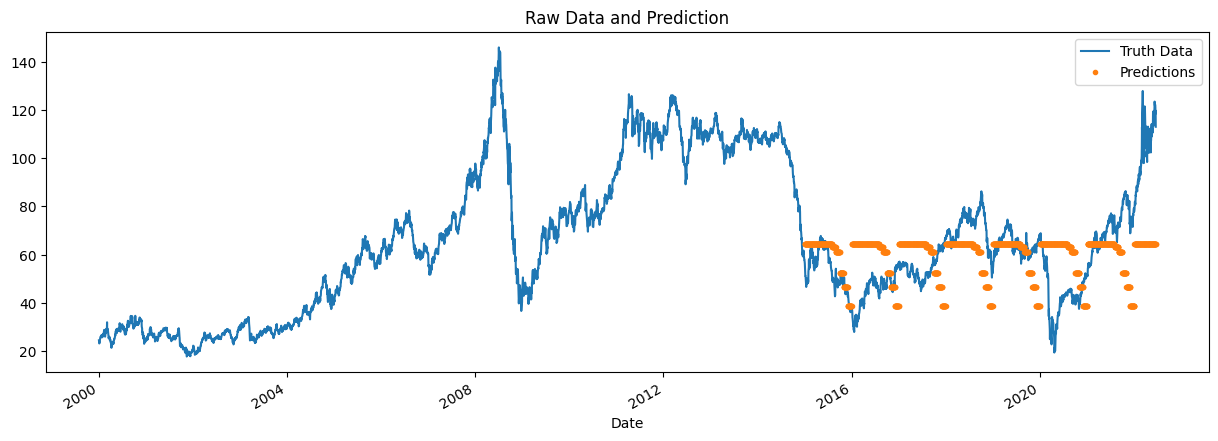

In [ ]:
test['prediction'] = best_reg.predict(X_test) # Use best_reg instead of reg
# Reset index of both dataframes before merging to avoid potential index mismatches
# Drop the 'prediction' column from df1_final if it exists to avoid conflicts
if 'prediction' in df1_final.columns:
    df1_final = df1_final.drop(columns=['prediction'])
df1_final = df1_final.reset_index()
test = test.reset_index()
df1_final = df1_final.merge(test[['Date', 'prediction']], how='left', on='Date')
# Set the index back to 'Date' after merging
df1_final = df1_final.set_index('Date')
ax = df1_final[['Close']].plot(figsize=(15, 5))
df1_final['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = df1_final['Close'].dropna()  # Drop any NaN values from the actual values
y_pred = df1_final.loc[y_true.index, 'prediction']  # Select predictions corresponding to actual values
# Assuming you have df1_final with 'Close' (actual values) and 'prediction' (predicted values)
y_true = df1_final['Close'].dropna()  # Drop any NaN values from the actual values
y_pred = df1_final.loc[y_true.index, 'prediction']  # Select predictions corresponding to actual values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate accuracy (R-squared)
from sklearn.metrics import r2_score
accuracy = r2_score(y_true, y_pred)

print(f"RMSE: {rmse}")
print(f"Accuracy (R-squared): {accuracy}")

ValueError: Input contains NaN.

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have df1_final with 'Close' (actual values) and 'prediction' (predicted values)
y_true = df1_final['Close'].dropna()  # Drop any NaN values from the actual values
y_pred = df1_final.loc[y_true.index, 'prediction']  # Select predictions corresponding to actual values

# Filter out NaN values from both y_true and y_pred to ensure they have the same length
# and contain only valid numeric values
mask = np.isfinite(y_true) & np.isfinite(y_pred)
y_true = y_true[mask]
y_pred = y_pred[mask]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate accuracy (R-squared)
from sklearn.metrics import r2_score
accuracy = r2_score(y_true, y_pred)

print(f"RMSE: {rmse}")
print(f"Accuracy (R-squared): {accuracy}")

RMSE: 18.47401071618325
Accuracy (R-squared): -0.17018967428016385
